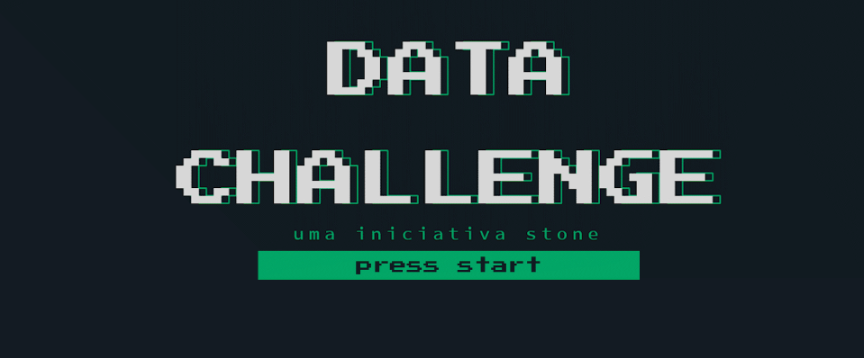

In [2]:
Image( '../../images/data_challenge.png')

# 0.0. IMPORTS

In [3]:
import pandas   as pd
import seaborn  as sns

from IPython.display       import Image
from IPython.core.display  import HTML

from scipy                 import stats           as ss

## 0.1. Aux Functions

In [4]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 15

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.4f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

# cramer v
def cramer_v( x, y ):

    cm   = pd.crosstab( x, y ).values

    chi2 = ss.chi2_contingency( cm )[0]
    n    = cm.sum()
    r, k = cm.shape
    
    chi2corr = max( 0, chi2 - ( k-1 ) * ( r- 1 ) / ( n-1 ) )
    kcorr    = k - ( k-1 )**2/( n-1 )
    rcorr    = r - ( r-1 )**2/( n-1 )

    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) )

def plot_cramer_v( columns_list, df ):
    corr_dict = {}
    for i in range( len ( columns_list ) ):
        corr_list = []
        for j in range( len( columns_list ) ):
            ref = columns_list[i]
            feat = columns_list[j]

            # correlation
            corr = cramer_v( df[ ref ], df[ feat ] )

            # append a list
            corr_list.append( corr )

        # appende a correlation list for each ref attributes
        corr_dict[ ref ] = corr_list

    # df
    correlations = pd.DataFrame( corr_dict )
    correlations = correlations.set_index( correlations.columns )

    return sns.heatmap( correlations, annot=True )

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Datasets

In [5]:
df_portfolio_clientes = pd.read_csv( '../../datasets/datasets_transformados/portfolio_clientes_final.csv' )
df_portfolio_comunicados = pd.read_csv( '../../datasets/datasets_transformados/portfolio_comunicados_final.csv' )
df_portfolio_geral_tpv = pd.read_csv( '../../datasets/datasets_transformados/portfolio_geral_tpv_final.csv' )

# Convertendo colunas de data pra datetime pois quando se exporta pra csv elas voltam para float

# ---- Portfolio Comunicados ----- #

# dt_ref_portfolio
df_portfolio_comunicados['dt_ref_portfolio'] = pd.to_datetime( df_portfolio_comunicados['dt_ref_portfolio'] )

# data_acao
df_portfolio_comunicados['data_acao'] = pd.to_datetime( df_portfolio_comunicados['data_acao'] )

# ---- Portfolio Geral TPV ----- #

# dt_ref_portfolio
df_portfolio_geral_tpv['dt_ref_portfolio']= pd.to_datetime( df_portfolio_geral_tpv['dt_ref_portfolio'] )

# safra
df_portfolio_geral_tpv['safra']= pd.to_datetime( df_portfolio_geral_tpv['safra'], format='%Y-%m' )

# dt_contrato
df_portfolio_geral_tpv['dt_contrato']= pd.to_datetime( df_portfolio_geral_tpv['dt_contrato'] )

# dt_desembolso
df_portfolio_geral_tpv['dt_desembolso']= pd.to_datetime( df_portfolio_geral_tpv['dt_desembolso'] )

# dt_vencimento
df_portfolio_geral_tpv['dt_vencimento']= pd.to_datetime( df_portfolio_geral_tpv['dt_vencimento'] )

# dt_wo
df_portfolio_geral_tpv['dt_wo']= pd.to_datetime( df_portfolio_geral_tpv['dt_wo'] )

In [6]:
# merge no portfolio geral tpv com o de clientes, 2 clientes excluídos por não terem cidade nem estado
df_geral_tpv_clientes = df_portfolio_geral_tpv.merge( df_portfolio_clientes, on='nr_documento', how='left' )
df_geral_tpv_clientes = df_geral_tpv_clientes.dropna()

# merge df aux com df comunicados formando df all - o objetivo aqui é filtrar apenas 
# as linhas do novo datafram que tiveram comunicados e formar um conjunto de dados só, com todas as informações
df_all = df_geral_tpv_clientes.merge( df_portfolio_comunicados, left_on=['contrato_id','dt_ref_portfolio'], right_on=['contrato_id','data_acao'], how='inner' )

# 1.0. Análie Univariada

## 1.1. Variáveis Numéricas

### 1.1.1. DF Portfolio Geral TPV Clientes

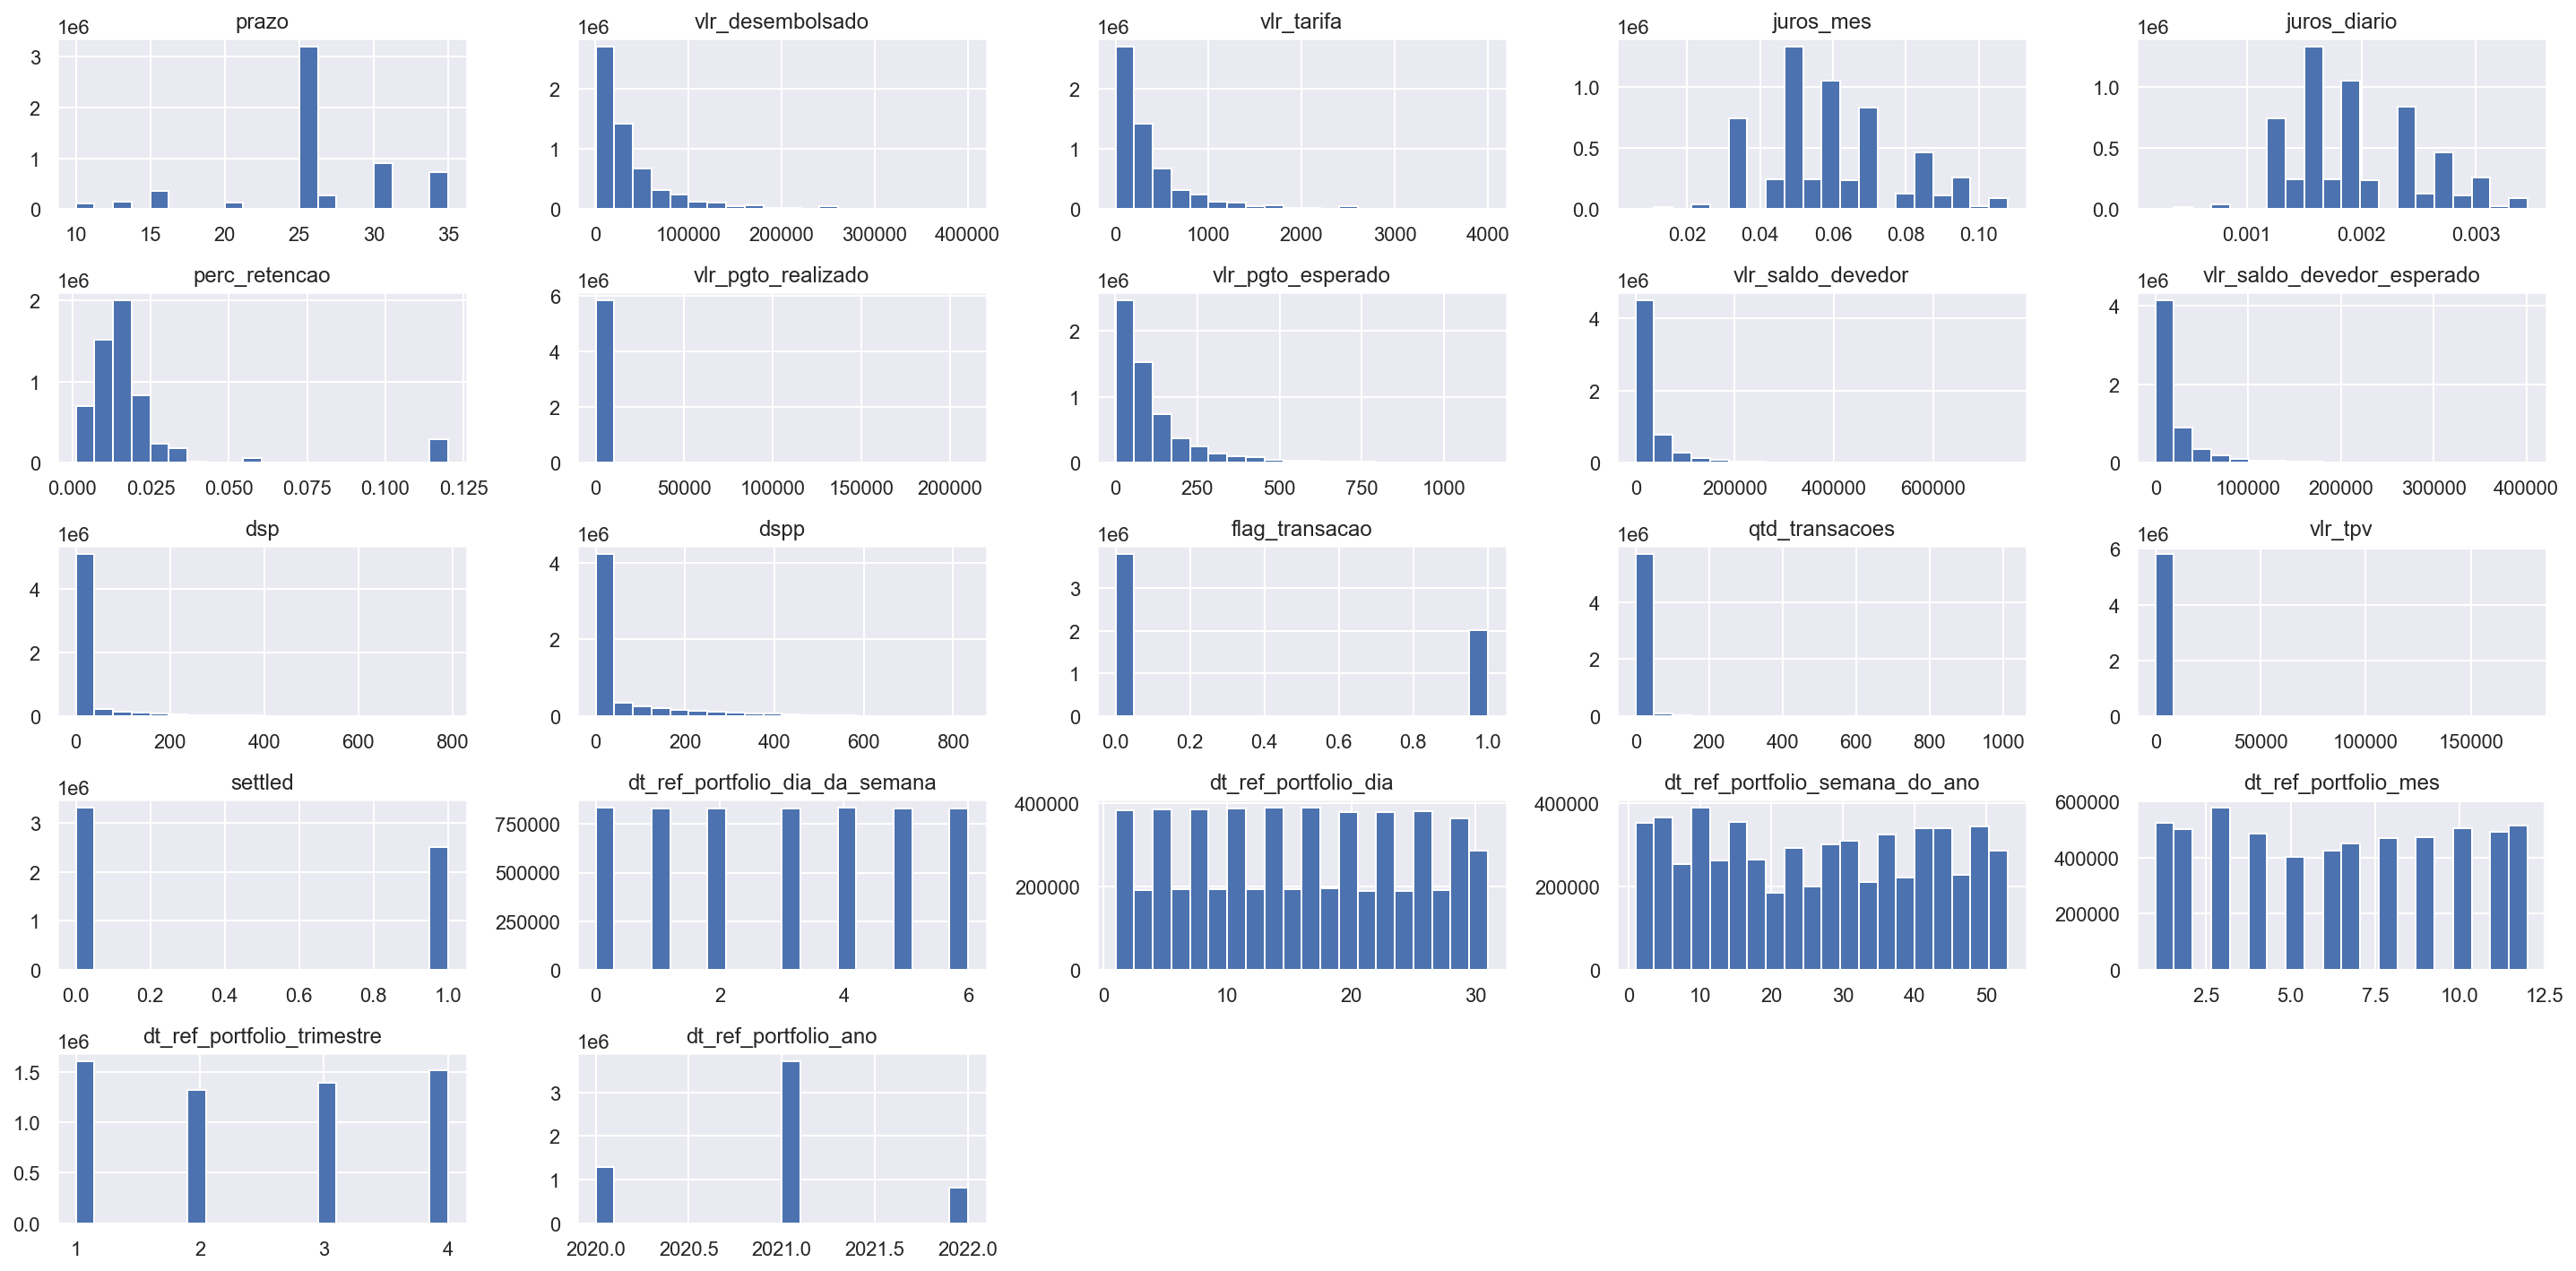

In [7]:
num_features_geral = df_geral_tpv_clientes.select_dtypes( include=['int64','float64'])
num_features_geral.hist( bins=20 );
tight_layout();

### 1.1.2. DF Portfolio Comunicados

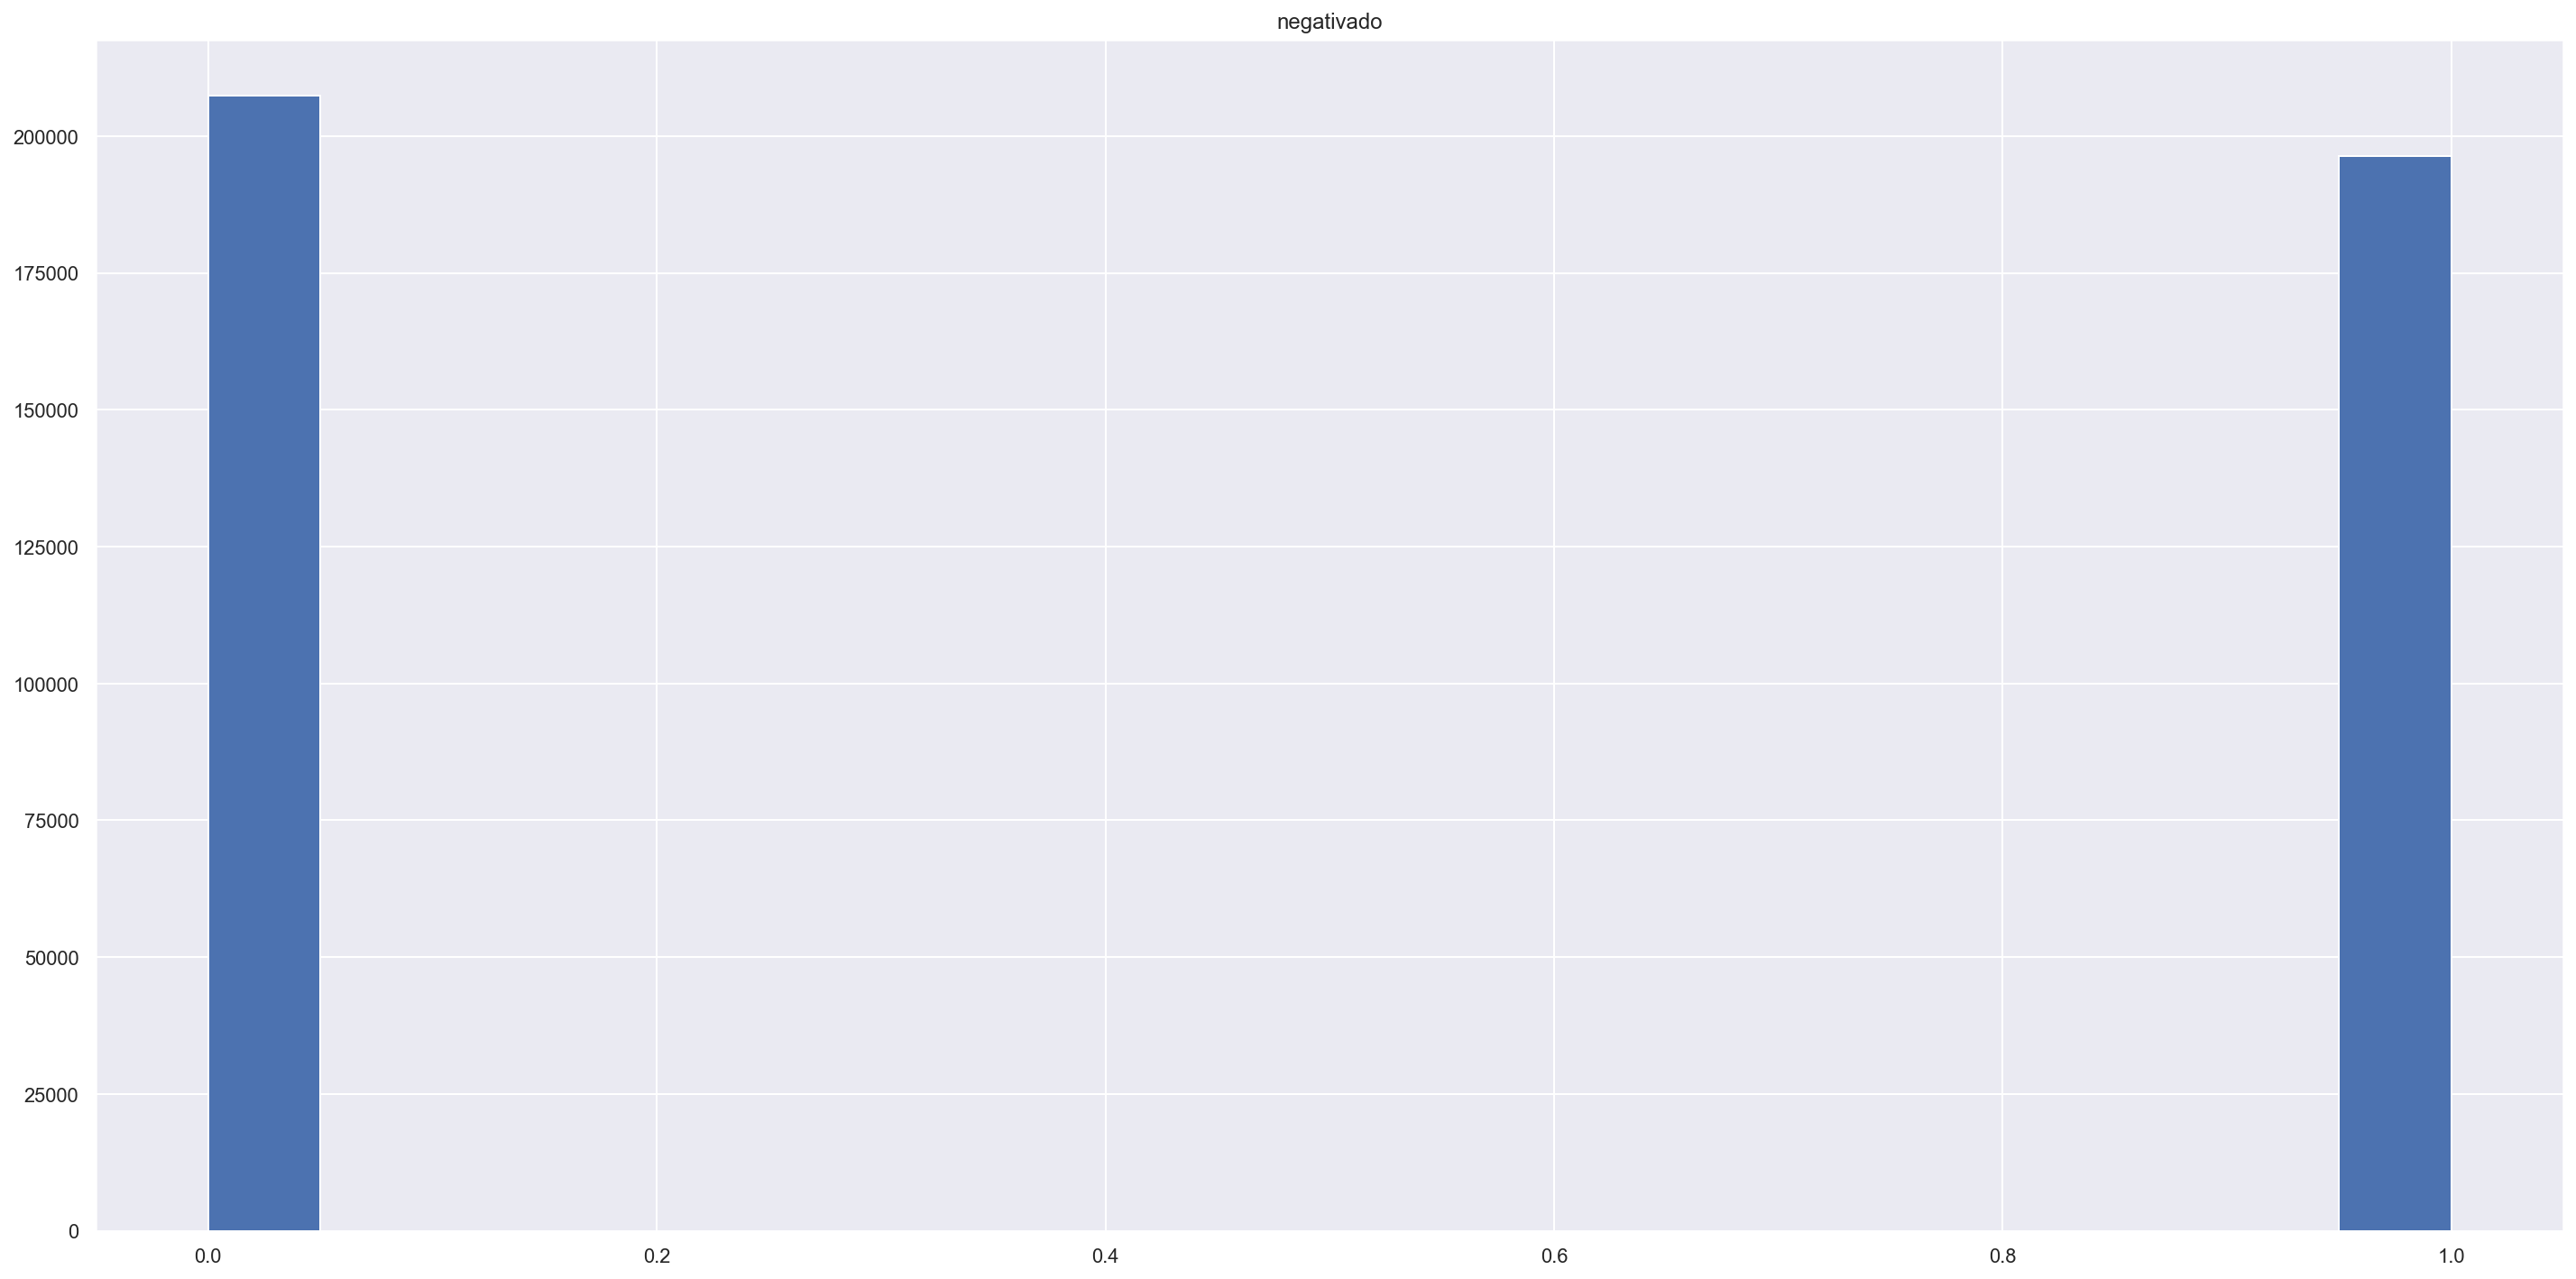

In [8]:
num_features_comunicados = df_portfolio_comunicados.select_dtypes( include=['int64','float64'])
num_features_comunicados.hist( bins=20 );
tight_layout();

# 2.0. Análise Bivariada

In [9]:
df_geral_tpv_clientes = df_geral_tpv_clientes.sort_values('dt_ref_portfolio')

## H1: 80% do valor total dos empréstimos concebidos estão concentrados em 20% dos contratos.
**Falso**. Na verdade, 80% do valor total dos empréstimos concebidos estão concentrados em 41% dos contratos.

In [10]:
df_valores_recebidos_por_contrato = df_geral_tpv_clientes[['contrato_id','vlr_desembolsado','vlr_pgto_realizado']].groupby(['contrato_id','vlr_desembolsado']).sum().reset_index()
df_valores_recebidos_por_contrato = df_valores_recebidos_por_contrato.sort_values( 'vlr_desembolsado', ascending=False )
df_valores_recebidos_por_contrato['emprestimos_acumulados'] = df_valores_recebidos_por_contrato['vlr_desembolsado'].cumsum()
df_valores_recebidos_por_contrato['perc_emprestimos_acumulados'] = df_valores_recebidos_por_contrato['vlr_desembolsado'].cumsum() / df_valores_recebidos_por_contrato['vlr_desembolsado'].sum()
df_valores_recebidos_por_contrato.head()

contrato_id  vlr_desembolsado  vlr_pgto_realizado  emprestimos_acumulados  perc_emprestimos_acumulados
5670  62e4acccf269a7ae2861043a5f267842      400,225.5000        408,706.0100            400,225.5000                       0.0008
6888  77cbcd328fb8459d04d58032aa5807b8      384,750.0000        207,155.3400            784,975.5000                       0.0015
5202  5af680fd65e5726b5bc752482a248b59      384,750.0000        512,686.9900          1,169,725.5000                       0.0023
55    01047210d6a8cb1f6710b51657139a10      384,750.0000        323,677.8900          1,554,475.5000                       0.0030
6558  72690015a0ff71e639715e312329f42e      379,107.0000        159,838.1700          1,933,582.5000                       0.0038

In [11]:
oitenta_por_cento = df_valores_recebidos_por_contrato[df_valores_recebidos_por_contrato['perc_emprestimos_acumulados'] <= 0.8]
print( '{:.2f}% dos contratos concentram 80% dos empréstimos concebidos pela Stone'.format((len(oitenta_por_cento['contrato_id'])/len(df_valores_recebidos_por_contrato['contrato_id']))*100))

40.94% dos contratos concentram 80% dos empréstimos concebidos pela Stone


### Em qual segmento estão concentrados esses 41%?
**1. Alimentação 2. Bens duráveis 3. Varejo**

In [12]:
lista_quarenta_por_cento = oitenta_por_cento['contrato_id'].tolist()

df_lista_quarenta_por_cento = df_geral_tpv_clientes[df_geral_tpv_clientes['contrato_id'].isin(lista_quarenta_por_cento)]
df_lista_quarenta_por_cento = df_lista_quarenta_por_cento.drop_duplicates( subset=['contrato_id'], keep='first' )
segmentos_lista_quarenta_por_cento = df_lista_quarenta_por_cento[['contrato_id','segmento']].groupby('segmento').count().reset_index().sort_values('contrato_id', ascending=False)

segmentos_lista_quarenta_por_cento

segmento  contrato_id
0               Alimentação         2291
1             Bens duráveis         1036
7                    Varejo         1030
6     Supermercado/Farmácia          684
4                  Serviços          665
5      Serviços recorrentes          111
3                     Posto          108
8  Viagens e entretenimento           74
2                    Outros           41

### E subsegmento?
**1. Alimentação Rápida 2. Lojas Diversas 3. Supermercados**

In [13]:
subsegmentos_lista_quarenta_por_cento = df_lista_quarenta_por_cento[['contrato_id','subsegmento']].groupby('subsegmento').count().reset_index().sort_values('contrato_id', ascending=False)

subsegmentos_lista_quarenta_por_cento

subsegmento  contrato_id
1       Alimentação Rápida         1228
8           Lojas Diversas         1149
14           Supermercados          612
5     Bares e Restaurantes          578
11                  Outros          520
15               Vestuário          383
4               Automotivo          372
13                   Saúde          363
9   Material de Construção          294
3       Atacadistas Gerais          192
12      Postos de Gasolina          108
6                 Educação           75
7          Lazer & Turismo           52
10                    None           45
0                Academias           40
2   Atacadista de Alimento           29

### Comparação Mediana de TPV Mensal por segmento - Mediana de pagamento esperado mensal por segmento
**Observa-se que as curvas são proporcionais, os segmentos com maior faturamento na máquina da stone tem maior valor de pagamento esperado. Provavelmente porque pegam empréstimos maiores.**

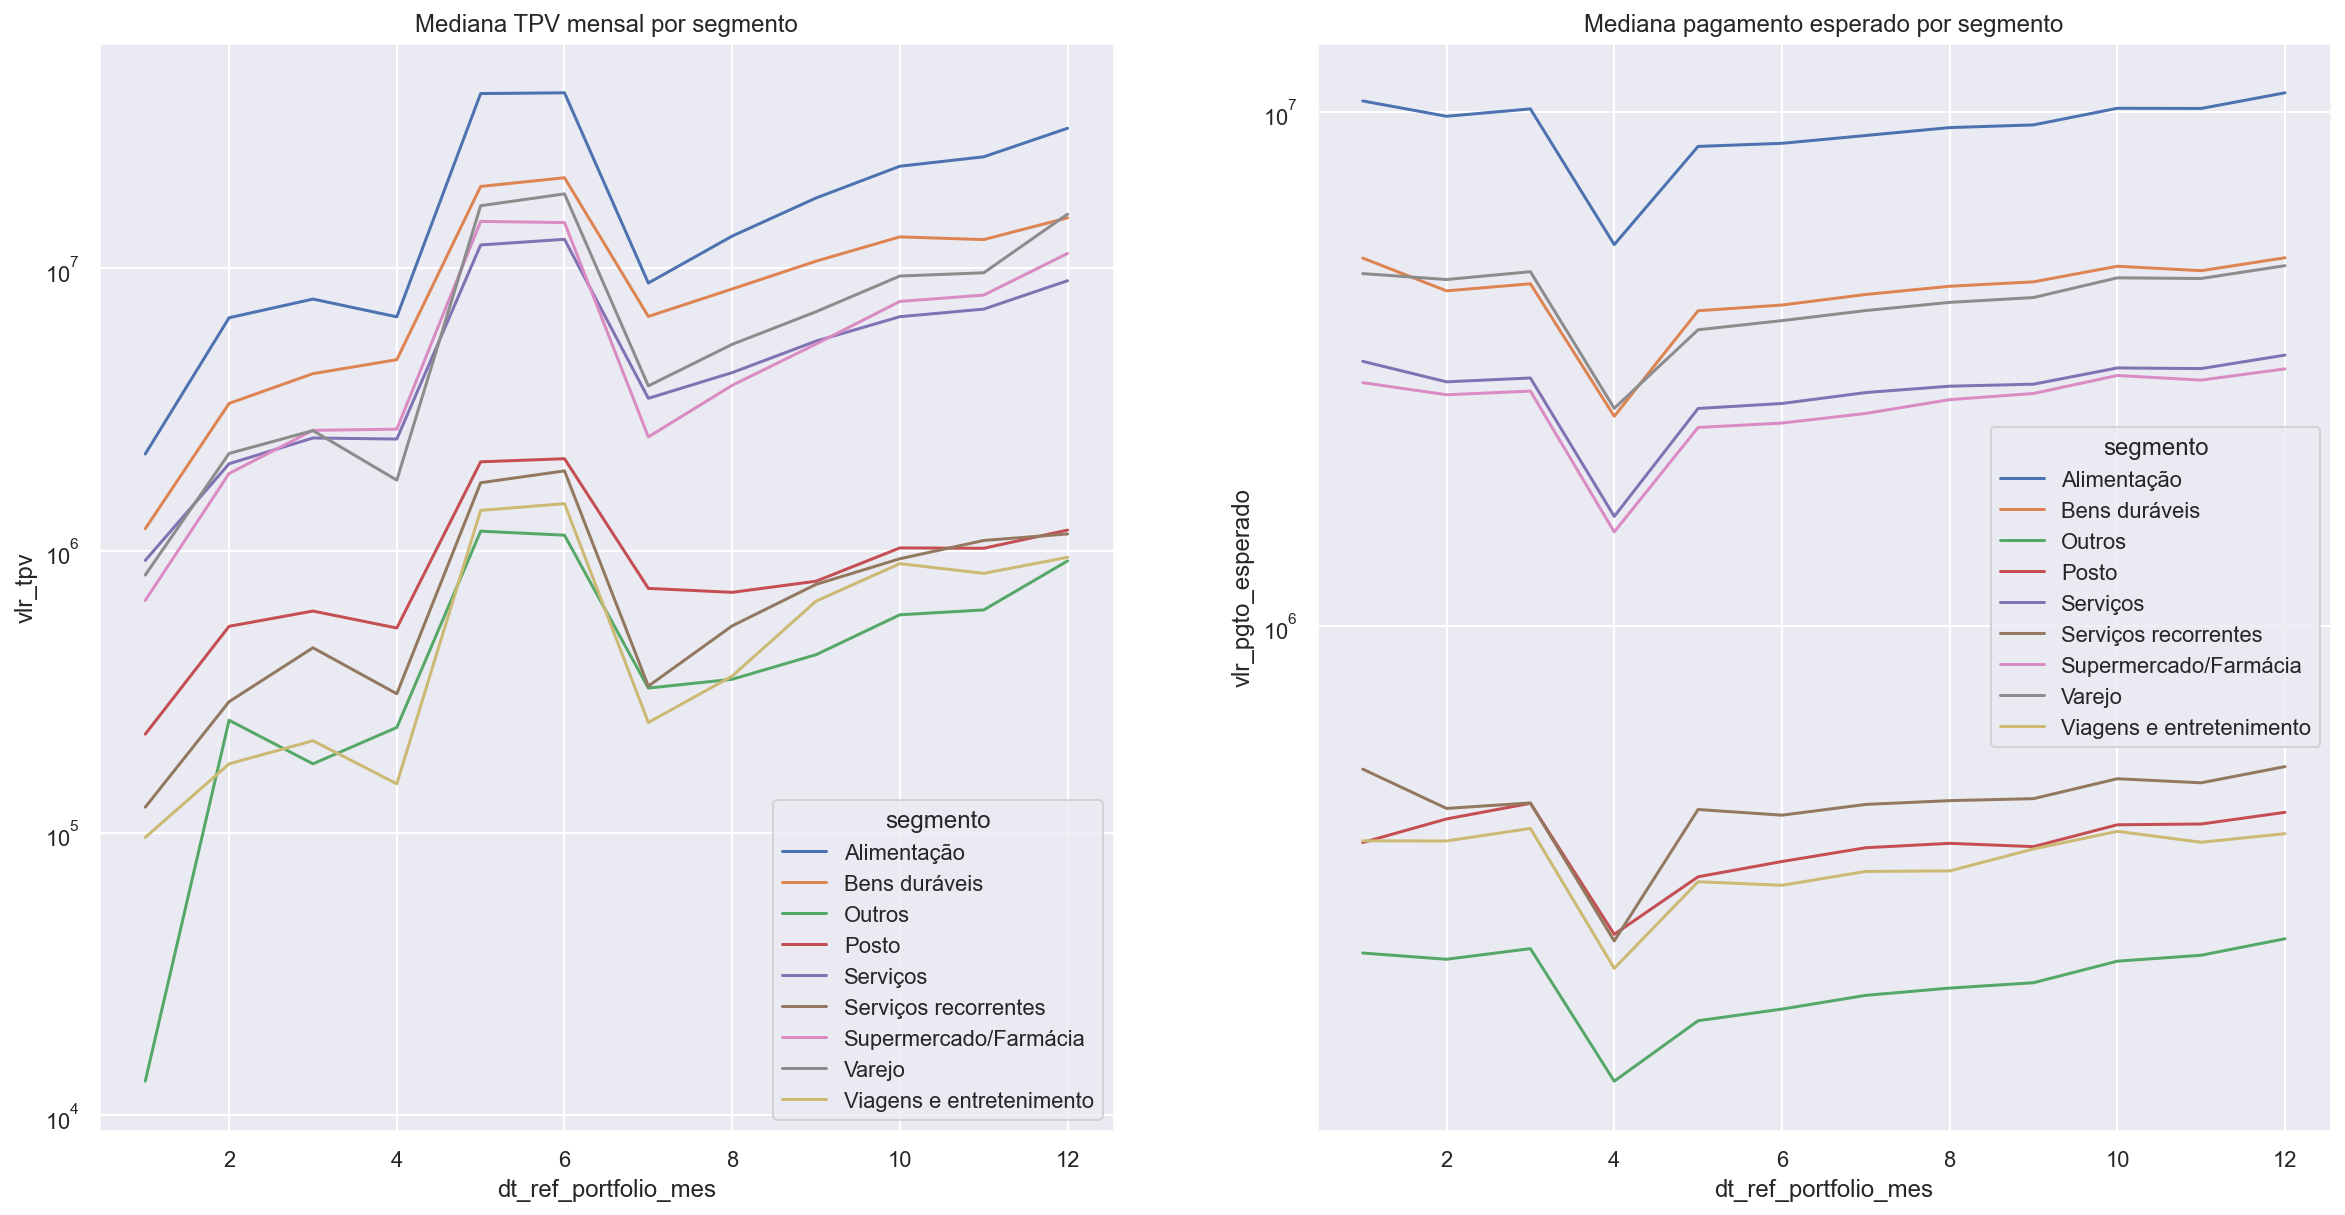

In [14]:
# mediana TPV mensal por segmento
tpv_mensal_segmento = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','segmento','vlr_tpv']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','segmento']).sum().reset_index()
tpv_mensal_segmento_mediana = tpv_mensal_segmento[['dt_ref_portfolio_mes','segmento','vlr_tpv']].groupby(['dt_ref_portfolio_mes','segmento']).median().reset_index()

# mediana pagamento esperado mensal por segmento
pagamento_esperado_mensal_segmento = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','segmento','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','segmento']).sum().reset_index()
pagamento_esperado_mensal_segmento_mediana = pagamento_esperado_mensal_segmento[['dt_ref_portfolio_mes','segmento','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_mes','segmento']).median().reset_index()

# plot grafico mediana TPV mensal por segmento
plt.subplot( 1, 2, 1 )
plt.title('Mediana TPV mensal por segmento')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_tpv', hue='segmento', data=tpv_mensal_segmento_mediana );
plt.yscale('log')

# plot grafico mediana pagamento esperado mensal por segmento
plt.subplot( 1, 2, 2 )
plt.title('Mediana pagamento esperado por segmento')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_pgto_esperado', hue='segmento', data=pagamento_esperado_mensal_segmento_mediana );
plt.yscale('log')

### Mediana de TPV Mensal por subsegmento - Mediana de pagamento esperado mensal por subsegmento

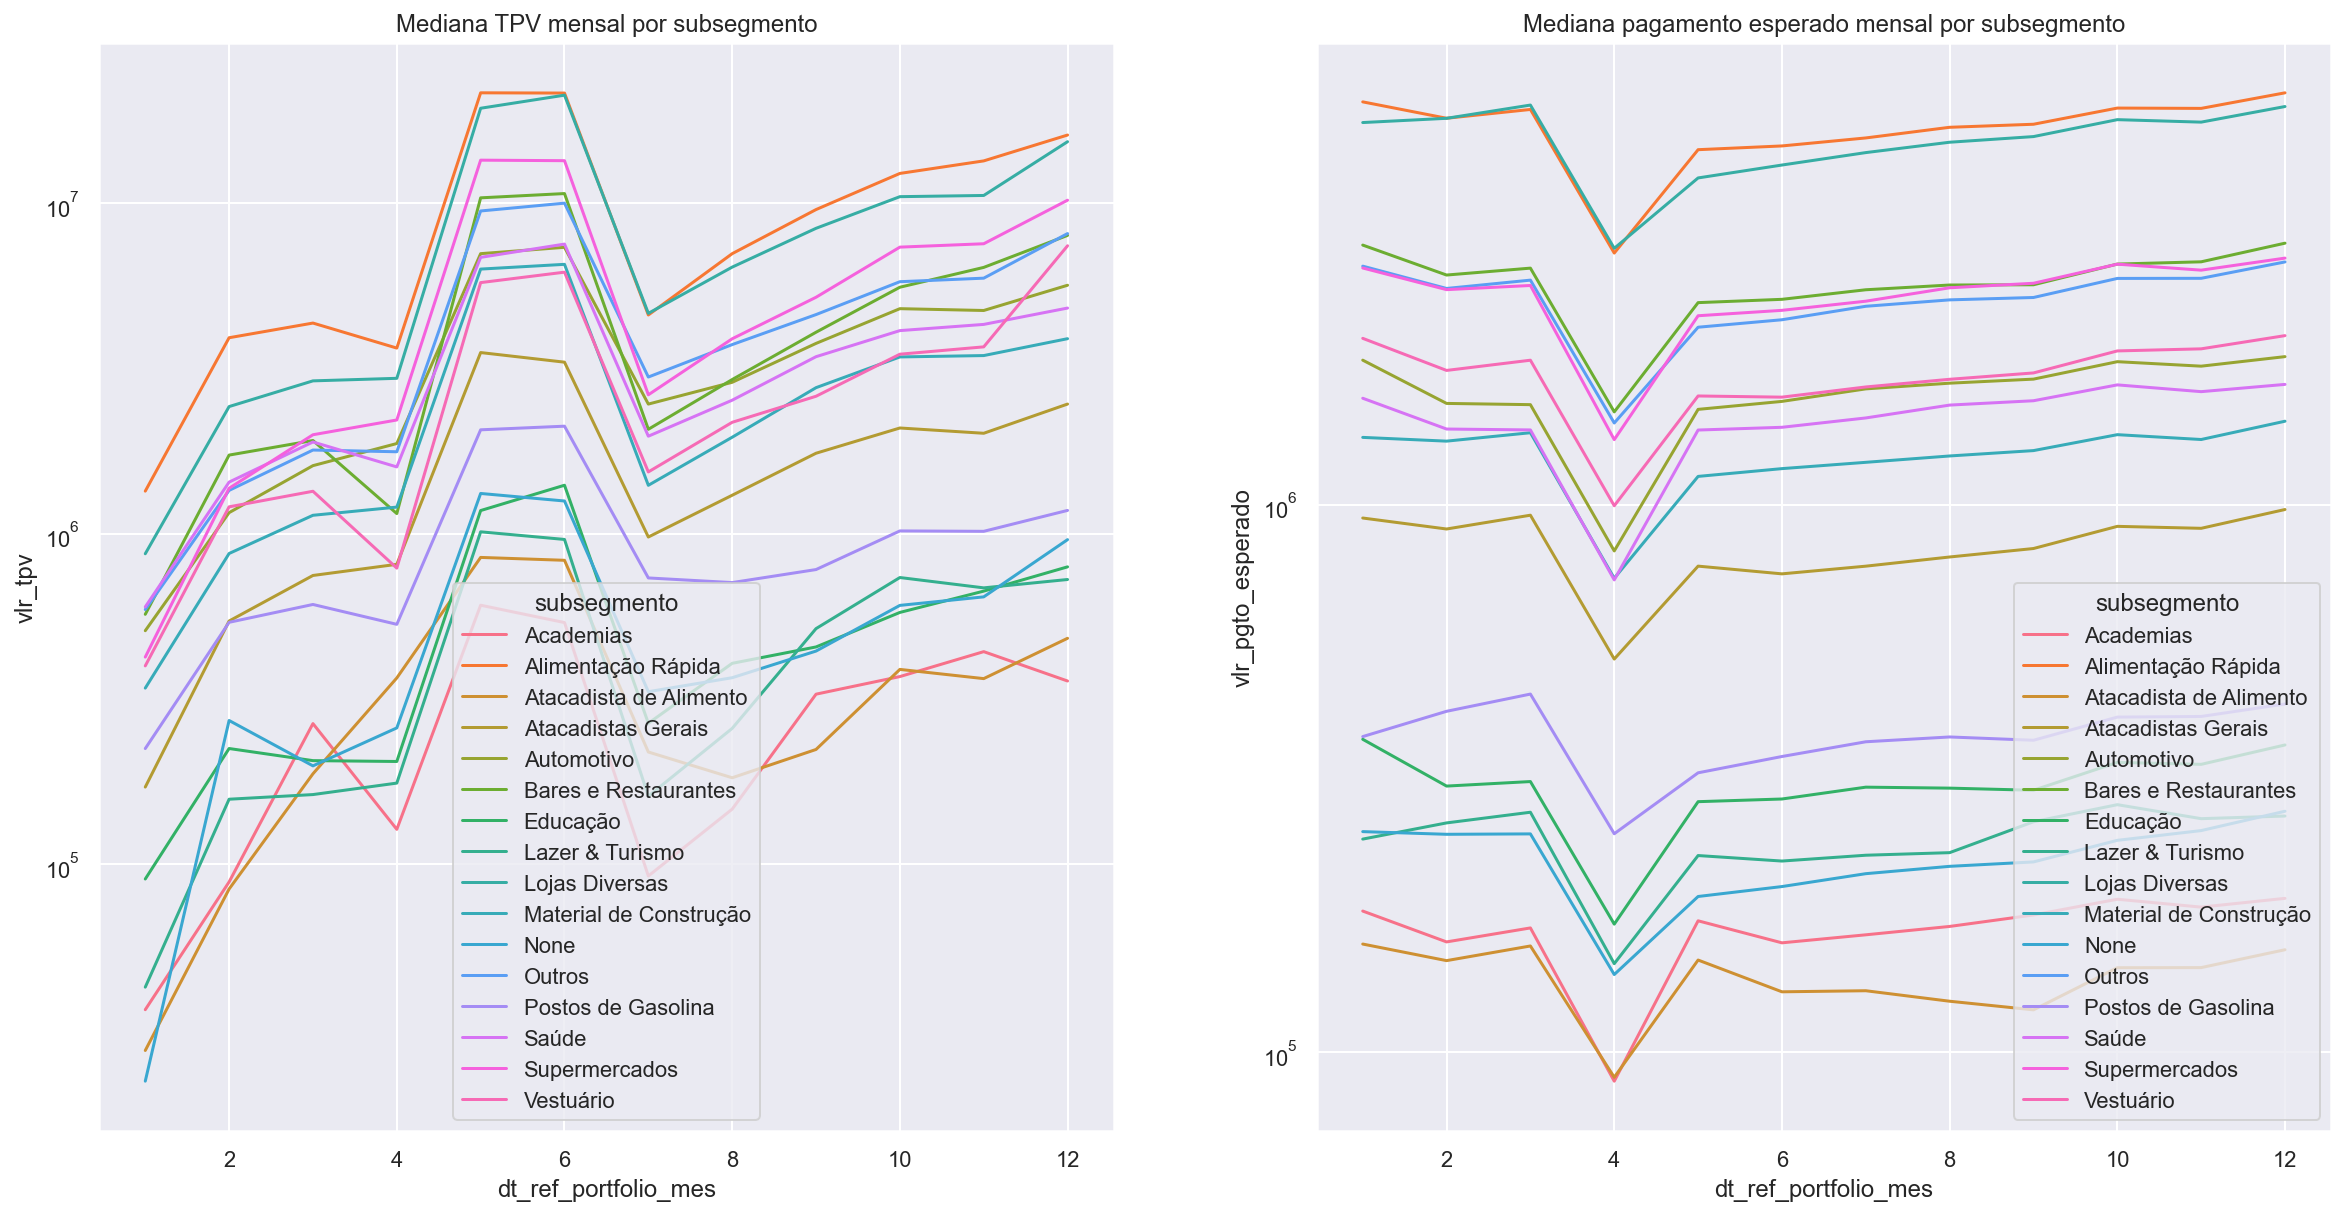

In [15]:
# mediana TPV mensal por subsegmento
tpv_mensal_subsegmento = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','subsegmento','vlr_tpv']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','subsegmento']).sum().reset_index()
tpv_mensal_subsegmento_mediana = tpv_mensal_subsegmento[['dt_ref_portfolio_mes','subsegmento','vlr_tpv']].groupby(['dt_ref_portfolio_mes','subsegmento']).median().reset_index()

# mediana pagamento esperado mensal por subsegmento
pagamento_esperado_mensal_subsegmento = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','subsegmento','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','subsegmento']).sum().reset_index()
pagamento_esperado_mensal_subsegmento_mediana = pagamento_esperado_mensal_subsegmento[['dt_ref_portfolio_mes','subsegmento','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_mes','subsegmento']).median().reset_index()

# plot grafico mediana TPV mensal por subsegmento
plt.subplot( 1, 2, 1 )
plt.title('Mediana TPV mensal por subsegmento')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_tpv', hue='subsegmento', data=tpv_mensal_subsegmento_mediana );
plt.yscale('log')

# plot grafico mediana pagamento esperado mensal por subsegmento
plt.subplot( 1, 2, 2 )
plt.title('Mediana pagamento esperado mensal por subsegmento')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_pgto_esperado', hue='subsegmento', data=pagamento_esperado_mensal_subsegmento_mediana );
plt.yscale('log')

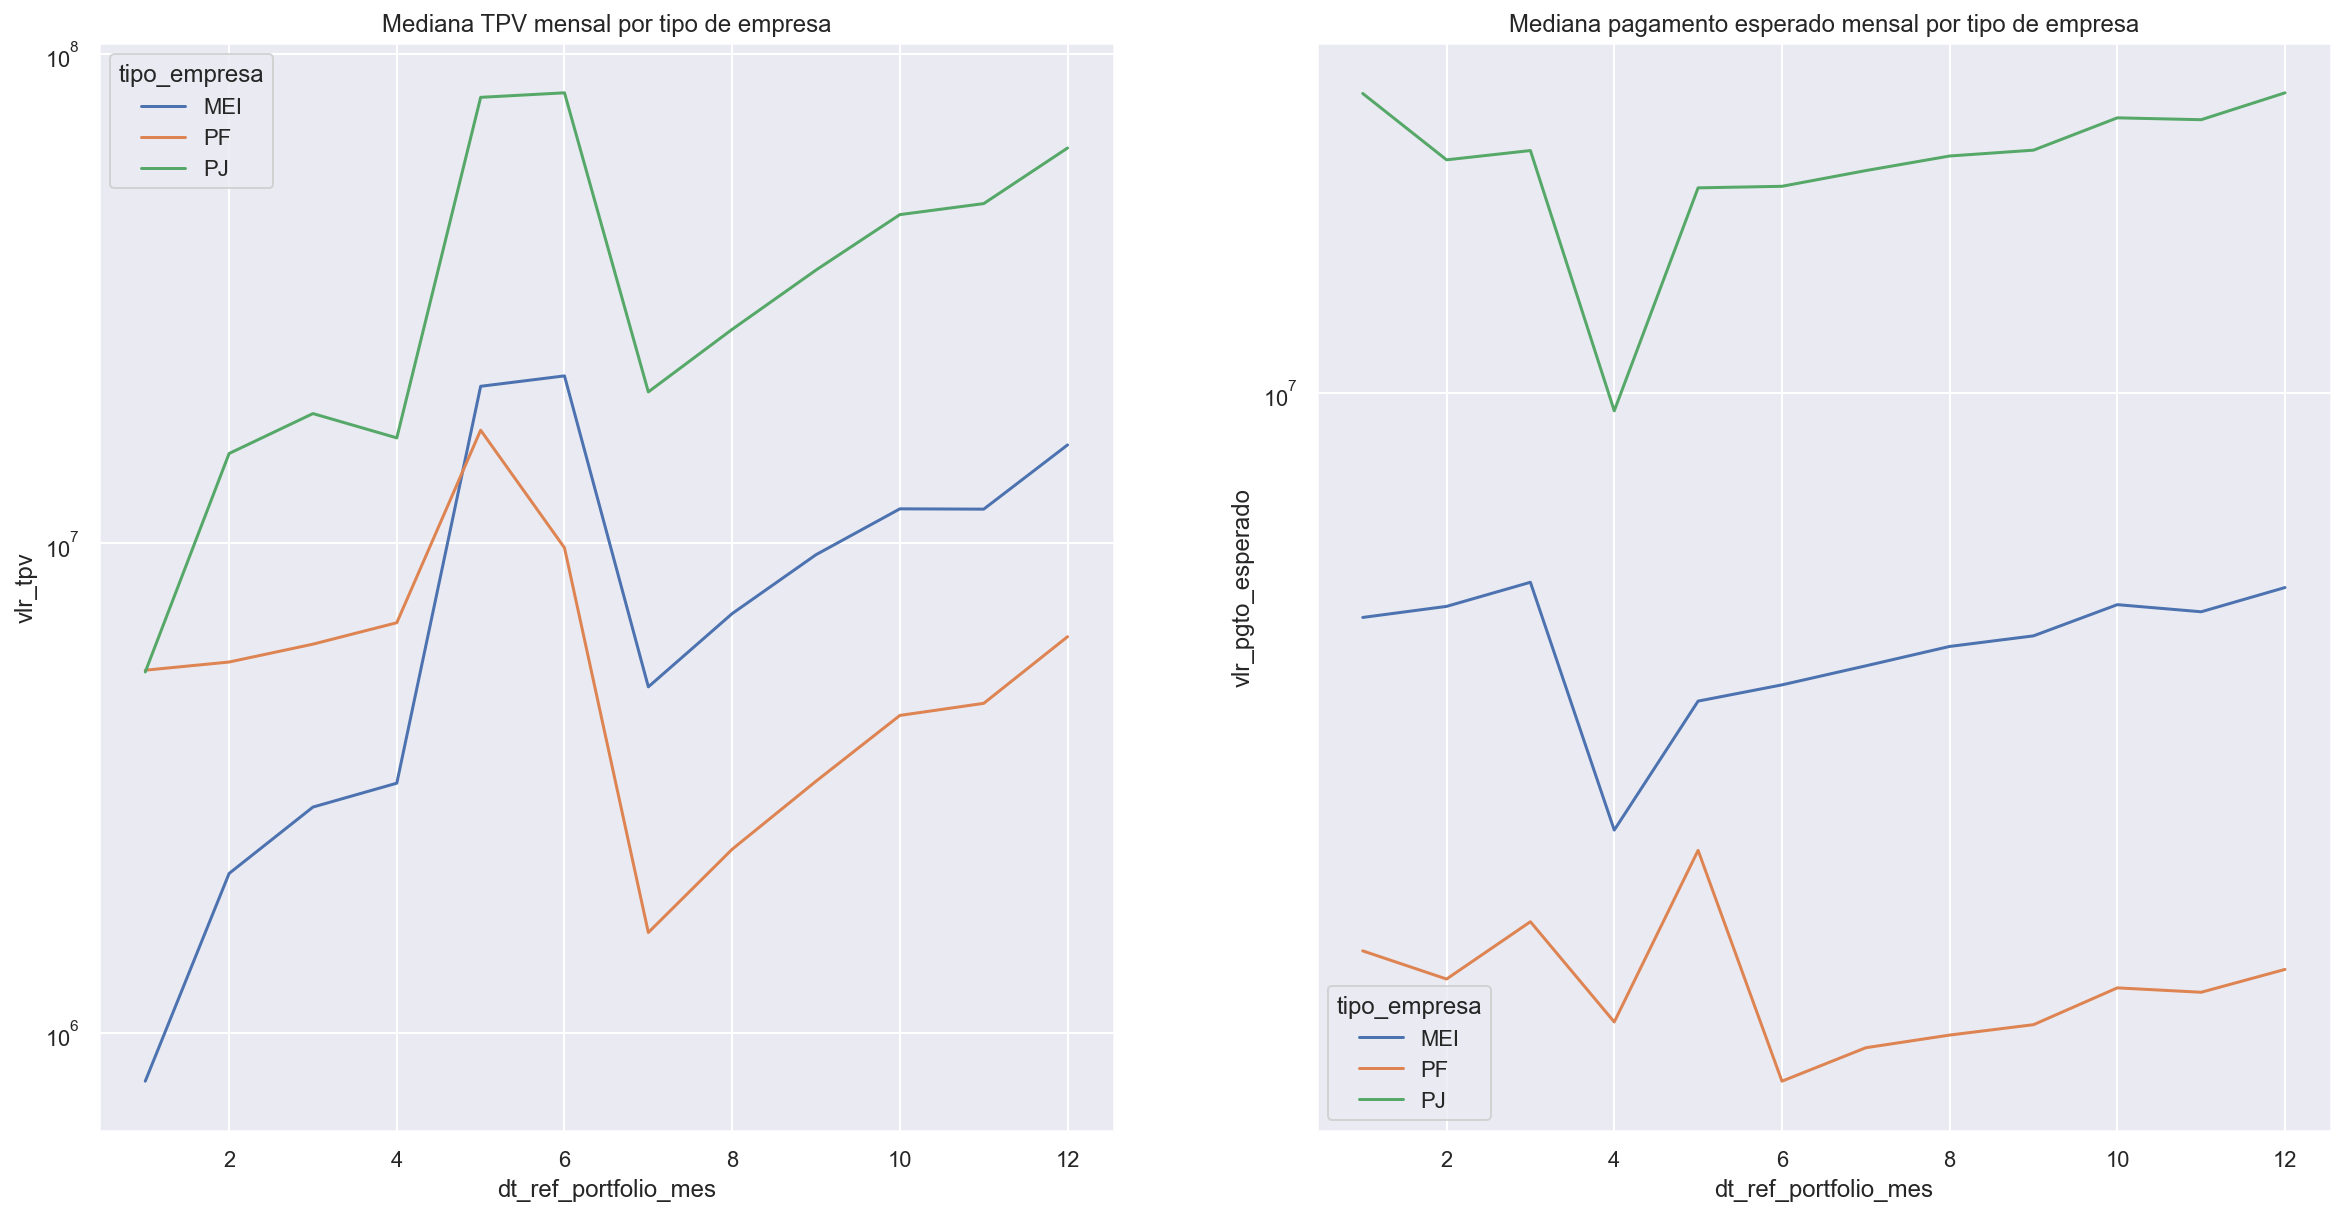

In [16]:
### Mediana de TPV Mensal por tipo empresa - Mediana de pagamento esperado mensal por tipo 

# mediana TPV mensal por tipo_empresa
tpv_mensal_tipo_empresa = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','tipo_empresa','vlr_tpv']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','tipo_empresa']).sum().reset_index()
tpv_mensal_tipo_empresa_mediana = tpv_mensal_tipo_empresa[['dt_ref_portfolio_mes','tipo_empresa','vlr_tpv']].groupby(['dt_ref_portfolio_mes','tipo_empresa']).median().reset_index()

# mediana pagamento esperado mensal por tipo_empresa
pagamento_esperado_mensal_tipo_empresa = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','tipo_empresa','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','tipo_empresa']).sum().reset_index()
pagamento_esperado_mensal_tipo_empresa_mediana = pagamento_esperado_mensal_tipo_empresa[['dt_ref_portfolio_mes','tipo_empresa','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_mes','tipo_empresa']).median().reset_index()

# plot grafico mediana TPV mensal por tipo_empresa
plt.subplot( 1, 2, 1 )
plt.title('Mediana TPV mensal por tipo de empresa')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_tpv', hue='tipo_empresa', data=tpv_mensal_tipo_empresa_mediana );
plt.yscale('log')

# plot grafico mediana pagamento esperado mensal por tipo_empresa
plt.subplot( 1, 2, 2 )
plt.title('Mediana pagamento esperado mensal por tipo de empresa')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_pgto_esperado', hue='tipo_empresa', data=pagamento_esperado_mensal_tipo_empresa_mediana );
plt.yscale('log')

### Mediana de TPV Mensal por Estado - Mediana de pagamento esperado mensal por estado

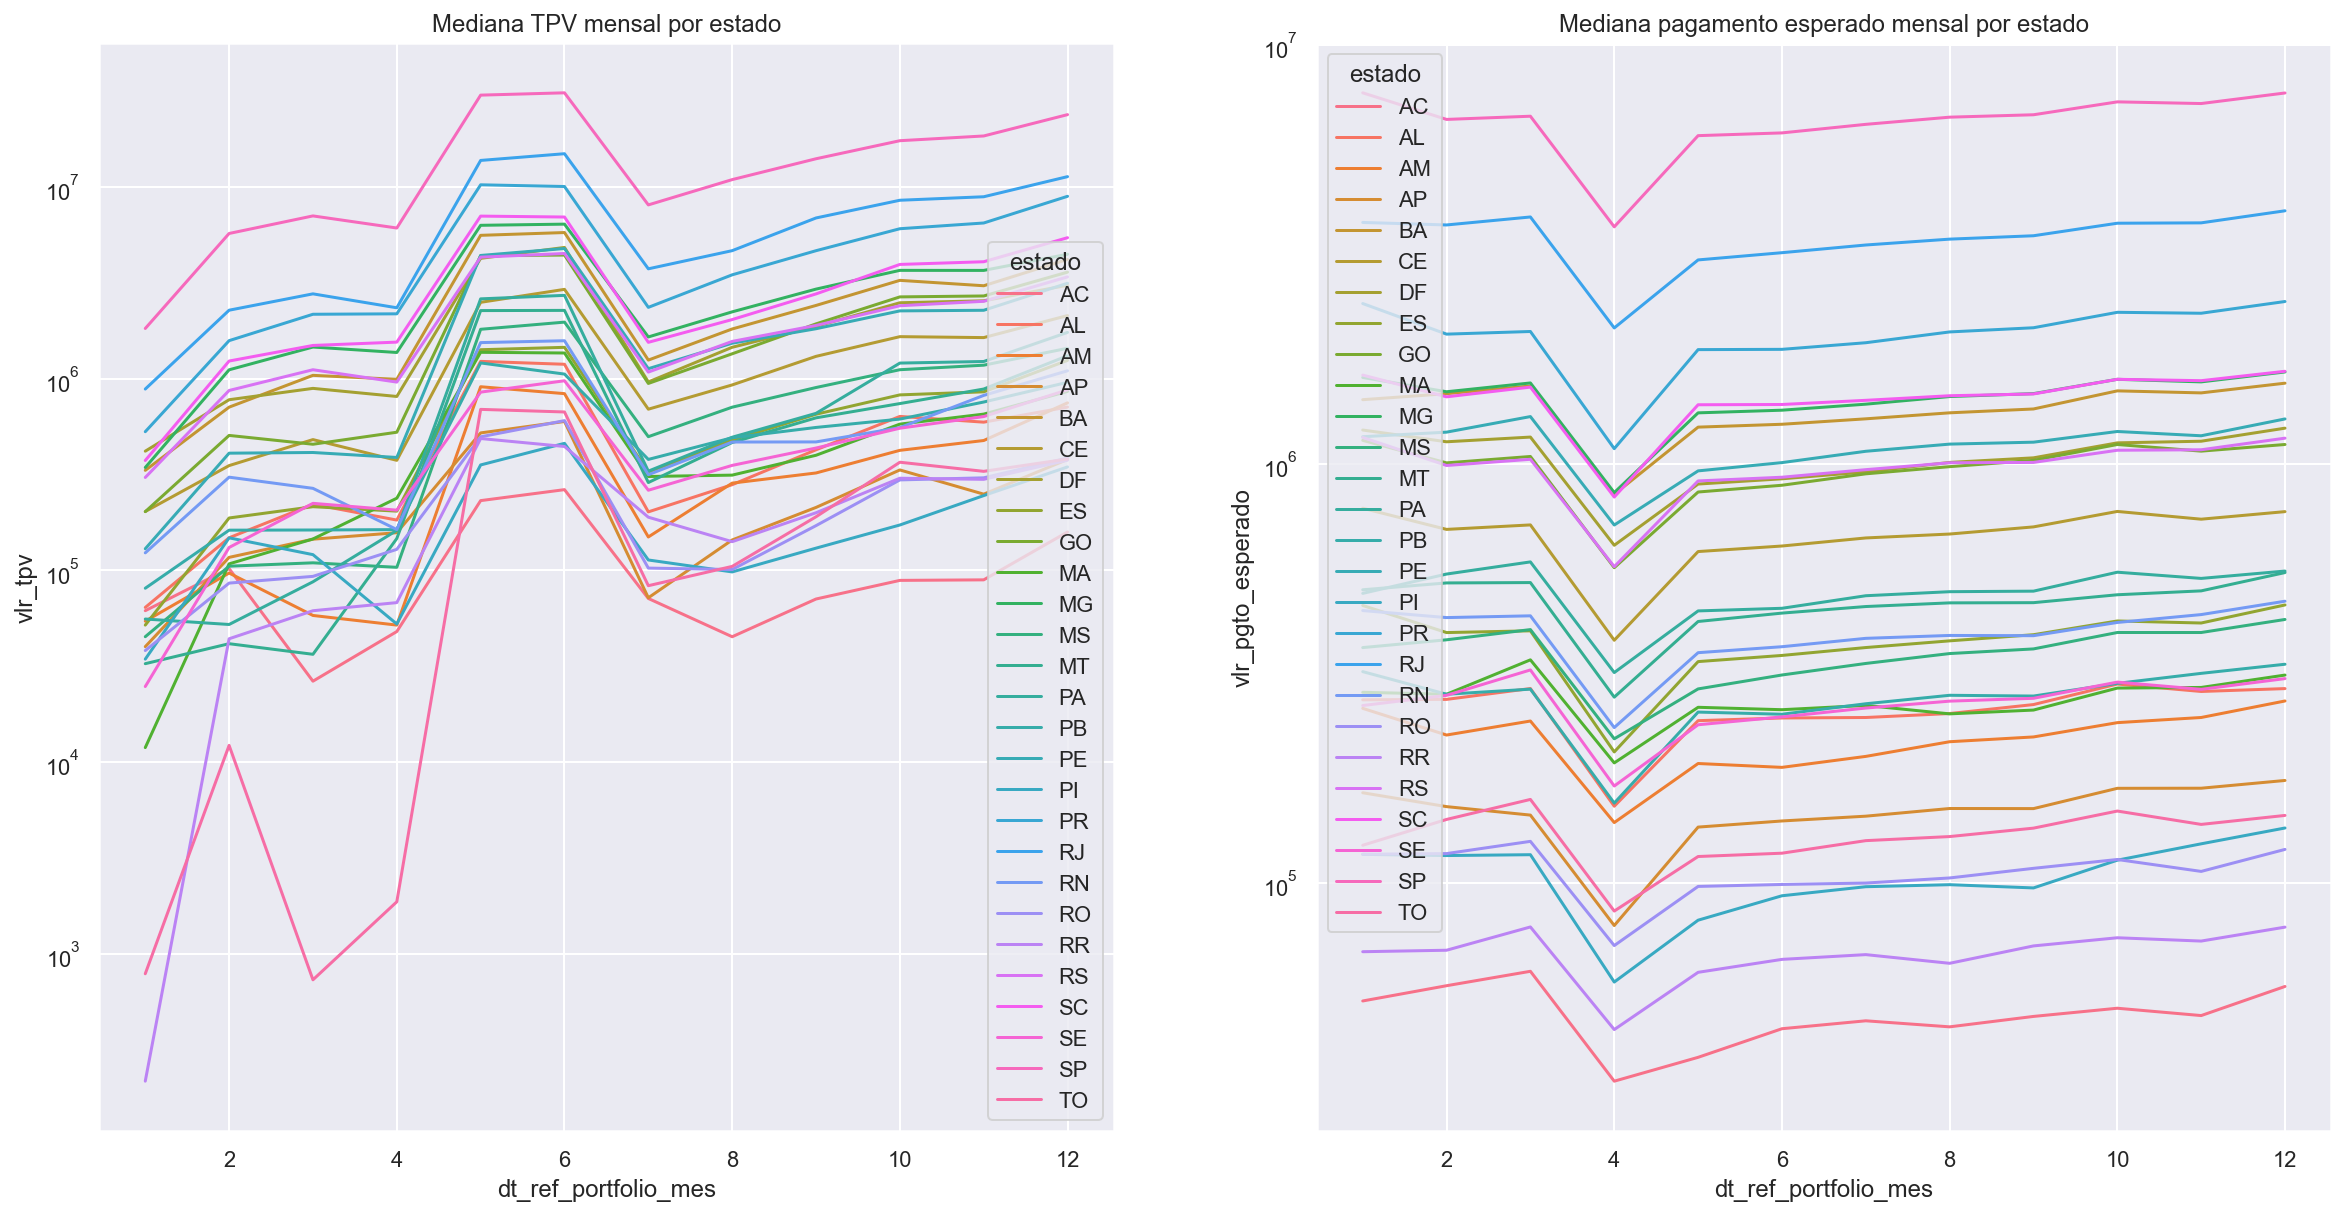

In [17]:
# mediana TPV mensal por estado
tpv_mensal_estado = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','estado','vlr_tpv']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','estado']).sum().reset_index()
tpv_mensal_estado_mediana = tpv_mensal_estado[['dt_ref_portfolio_mes','estado','vlr_tpv']].groupby(['dt_ref_portfolio_mes','estado']).median().reset_index()

# mediana pagamento esperado mensal por estado
pagamento_esperado_mensal_estado = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','estado','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','estado']).sum().reset_index()
pagamento_esperado_mensal_estado_mediana = pagamento_esperado_mensal_estado[['dt_ref_portfolio_mes','estado','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_mes','estado']).median().reset_index()

# plot grafico mediana TPV mensal por estado
plt.subplot( 1, 2, 1 )
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_tpv', hue='estado', data=tpv_mensal_estado_mediana );
plt.title('Mediana TPV mensal por estado')
plt.yscale('log')

# plot grafico mediana pagamento esperado mensal por estado
plt.subplot( 1, 2, 2 )
plt.title('Mediana pagamento esperado mensal por estado')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_pgto_esperado', hue='estado', data=pagamento_esperado_mensal_estado_mediana );
plt.yscale('log')

### Mediana de TPV Mensal por Região - Mediana de pagamento esperado mensal por Região

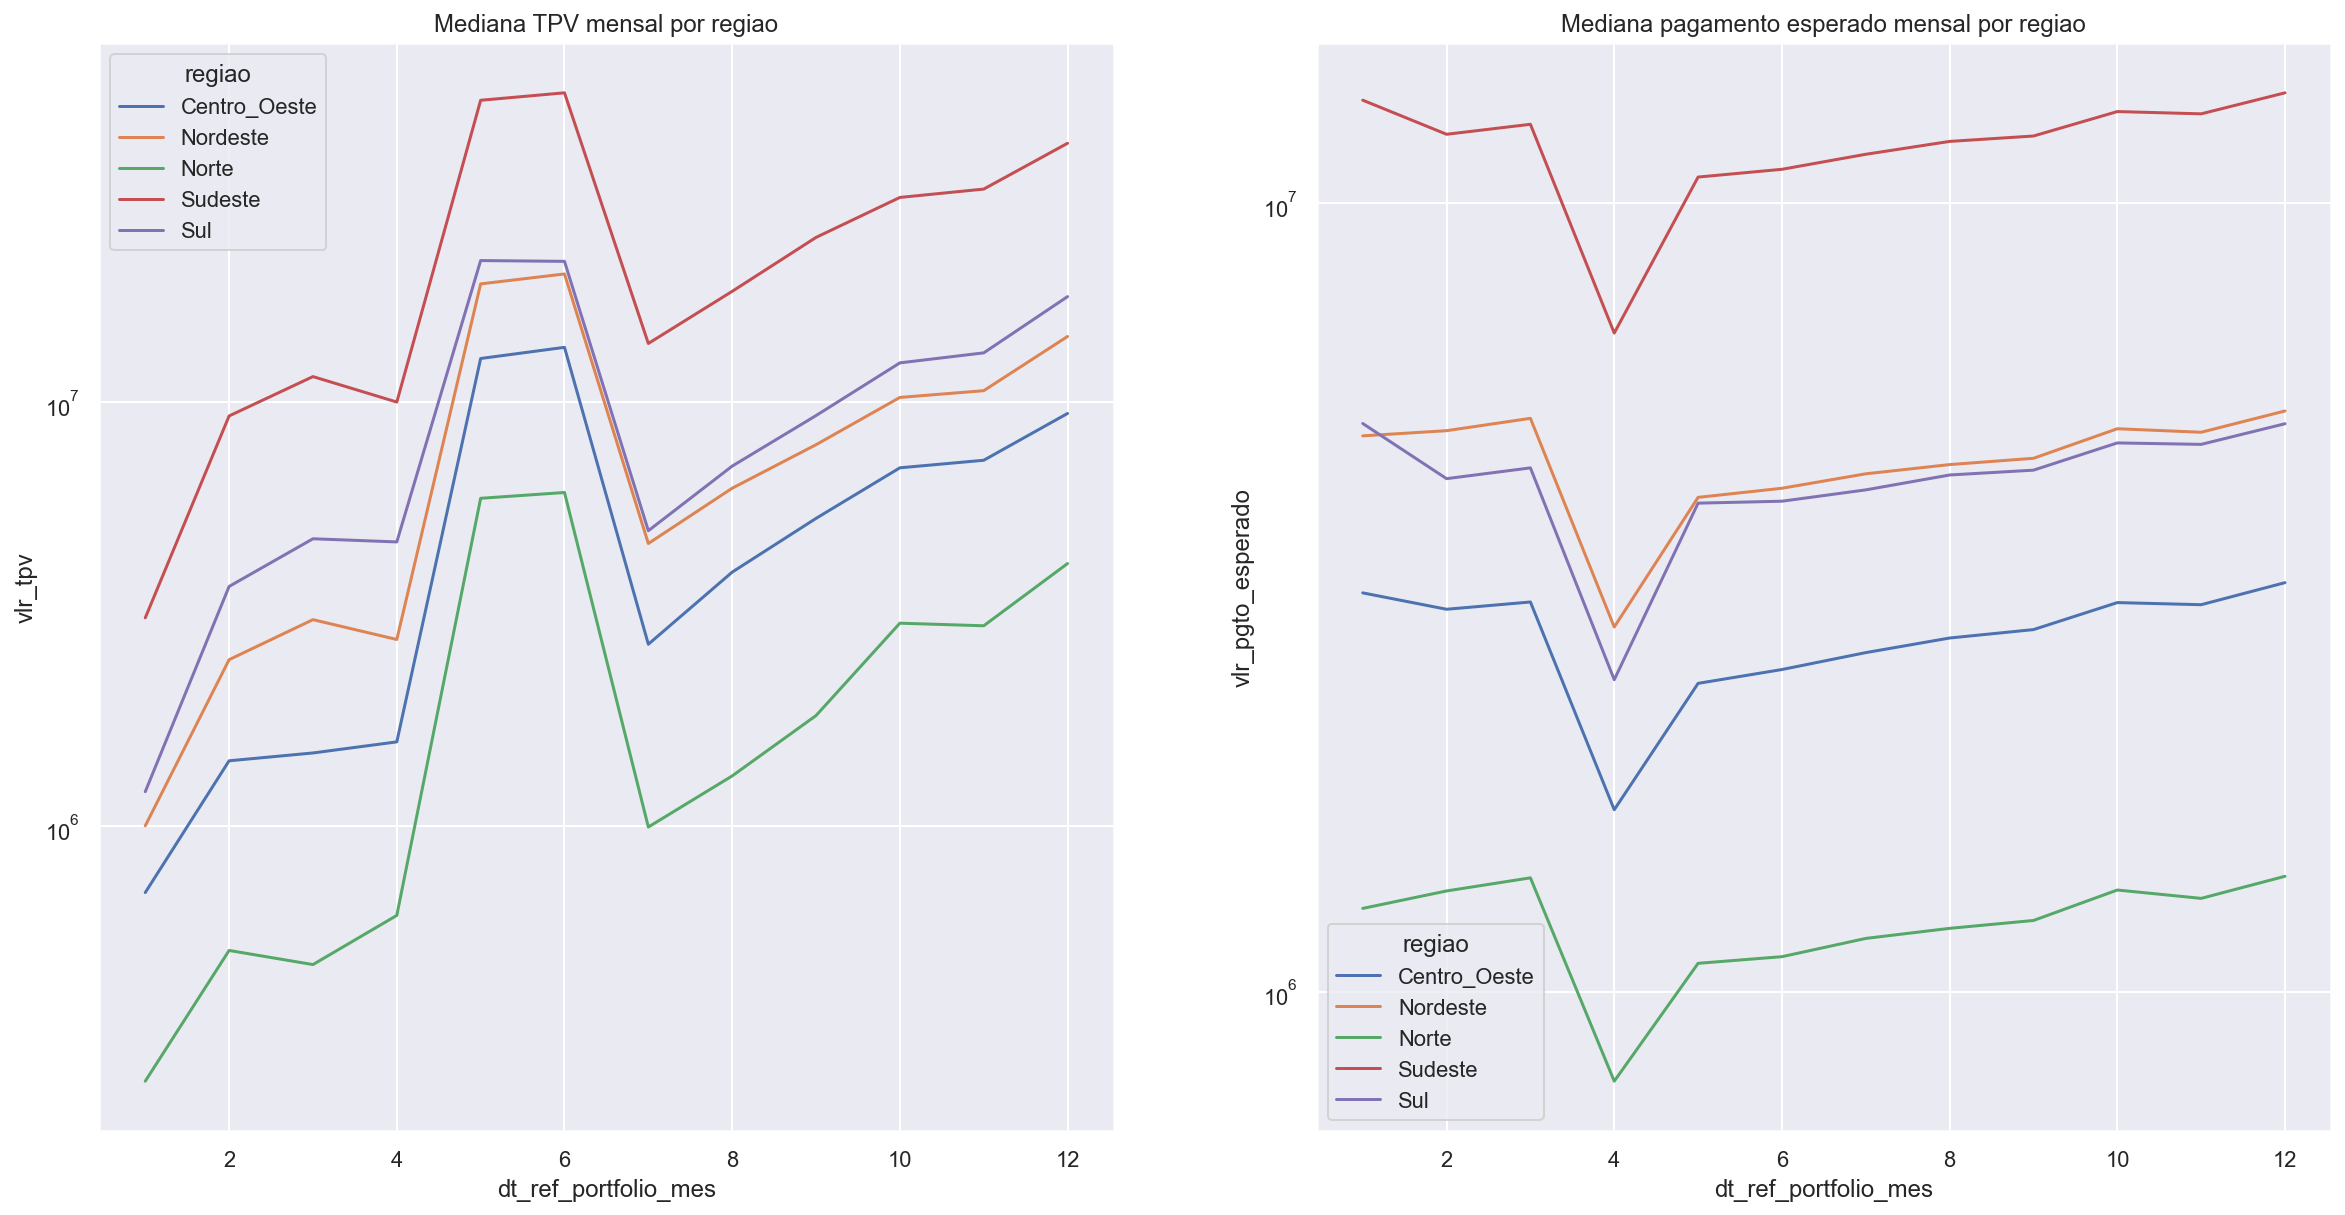

In [18]:
# mediana TPV mensal por regiao
tpv_mensal_regiao = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','regiao','vlr_tpv']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','regiao']).sum().reset_index()
tpv_mensal_regiao_mediana = tpv_mensal_regiao[['dt_ref_portfolio_mes','regiao','vlr_tpv']].groupby(['dt_ref_portfolio_mes','regiao']).median().reset_index()

# mediana pagamento esperado mensal por regiao
pagamento_esperado_mensal_regiao = df_geral_tpv_clientes[['dt_ref_portfolio_ano','dt_ref_portfolio_mes','regiao','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_ano','dt_ref_portfolio_mes','regiao']).sum().reset_index()
pagamento_esperado_mensal_regiao_mediana = pagamento_esperado_mensal_regiao[['dt_ref_portfolio_mes','regiao','vlr_pgto_esperado']].groupby(['dt_ref_portfolio_mes','regiao']).median().reset_index()

# plot grafico mediana TPV mensal por regiao
plt.subplot( 1, 2, 1 )
plt.title('Mediana TPV mensal por regiao')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_tpv', hue='regiao', data=tpv_mensal_regiao_mediana );
plt.yscale('log')

# plot grafico mediana pagamento esperado mensal por regiao
plt.subplot( 1, 2, 2 )
plt.title('Mediana pagamento esperado mensal por regiao')
sns.lineplot( x='dt_ref_portfolio_mes', y='vlr_pgto_esperado', hue='regiao', data=pagamento_esperado_mensal_regiao_mediana );
plt.yscale('log')

## H2: 80% do lucro total ( juros ) sobre os empréstimos concebidos estão concentrados em 20% dos contratos.
**Falso**. Na verdade, a Stone tem um prejuízo de R$:13,948,731 e esse prejuízo vem de 35% dos contratos.

In [19]:
df_valores_recebidos_por_contrato['lucro'] = df_valores_recebidos_por_contrato['vlr_pgto_realizado'] - df_valores_recebidos_por_contrato['vlr_desembolsado']
df_valores_recebidos_por_contrato = df_valores_recebidos_por_contrato.sort_values( 'lucro', ascending=False )
df_valores_recebidos_por_contrato['lucro_acumulado'] = df_valores_recebidos_por_contrato['lucro'].cumsum()
df_valores_recebidos_por_contrato.head()

contrato_id  vlr_desembolsado  vlr_pgto_realizado  emprestimos_acumulados  perc_emprestimos_acumulados        lucro  lucro_acumulado
3459   3cdb86b8d2e1f33093c9f77807202054      256,500.0000        421,444.1400         16,660,793.3400                       0.0324 164,944.1400     164,944.1400
10438  b4474e60081abd8fa2690ee8eeaee6e7      174,440.5200        328,896.8100         59,772,819.1500                       0.1162 154,456.2900     319,400.4300
10138  af465c295f13909fe882645d9ec74f0a      256,500.0000        394,703.1300          6,144,293.3400                       0.0119 138,203.1300     457,603.5600
13463  e939d9e82e7bfd1e104b26cf00234a97      205,200.0000        342,671.9000         46,639,088.9100                       0.0907 137,471.9000     595,075.4600
5202   5af680fd65e5726b5bc752482a248b59      384,750.0000        512,686.9900          1,169,725.5000                       0.0023 127,936.9900     723,012.4500

In [20]:
contratos_prejuizo = df_valores_recebidos_por_contrato[df_valores_recebidos_por_contrato['lucro'] < 0 ]

In [21]:
valor_prejuizo = df_valores_recebidos_por_contrato['lucro_acumulado'].iloc[-1]

In [22]:
print( '{:.2f}% dos contratos concentram todo o prejuízo da Stone'.format((len(contratos_prejuizo['contrato_id'])/len(df_valores_recebidos_por_contrato['contrato_id']))*100))
print( 'O valor do prejuízo é {} milhões'.format( valor_prejuizo ) )

35.56% dos contratos concentram todo o prejuízo da Stone
O valor do prejuízo é -13948731.230000602 milhões


### Em qual segmento estão concentrados esses 35%?
**1. Alimentação 2. Varejo 3. Bens Duráveis**

In [23]:
lista_trinta_e_cinco_por_cento = contratos_prejuizo['contrato_id'].tolist()

df_lista_trinta_e_cinco_por_cento = df_geral_tpv_clientes[df_geral_tpv_clientes['contrato_id'].isin(lista_trinta_e_cinco_por_cento)]
df_lista_trinta_e_cinco_por_cento = df_lista_trinta_e_cinco_por_cento.drop_duplicates( subset=['contrato_id'], keep='first' )
segmentos_lista_trinta_e_cinco_por_cento = df_lista_trinta_e_cinco_por_cento[['contrato_id','segmento']].groupby('segmento').count().reset_index().sort_values('contrato_id', ascending=False)
segmentos_lista_trinta_e_cinco_por_cento['perc_acumulado'] = ( segmentos_lista_trinta_e_cinco_por_cento['contrato_id'].cumsum() / segmentos_lista_trinta_e_cinco_por_cento['contrato_id'].sum() ) * 100
segmentos_lista_trinta_e_cinco_por_cento

segmento  contrato_id  perc_acumulado
0               Alimentação         1859         35.4298
7                    Varejo         1033         55.1172
1             Bens duráveis          847         71.2598
4                  Serviços          815         86.7925
6     Supermercado/Farmácia          446         95.2925
5      Serviços recorrentes           93         97.0650
8  Viagens e entretenimento           73         98.4563
3                     Posto           60         99.5998
2                    Outros           21        100.0000

In [ ]:
segmentos_lista_trinta_e_cinco_por_cento.to_csv('../../datasets/datasets_transformados/abc_segmento.csv')

### E subsegmento?
**1. Lojas Diversas 2. Alimentação Rápida 3. Outros**

In [25]:
subsegmentos_lista_trinca_e_cinco_por_cento = df_lista_trinta_e_cinco_por_cento[['contrato_id','subsegmento']].groupby('subsegmento').count().reset_index().sort_values('contrato_id', ascending=False)

subsegmentos_lista_trinca_e_cinco_por_cento

subsegmento  contrato_id
8           Lojas Diversas         1082
1       Alimentação Rápida         1036
11                  Outros          636
5     Bares e Restaurantes          456
14           Supermercados          423
4               Automotivo          381
15               Vestuário          372
13                   Saúde          242
9   Material de Construção          215
3       Atacadistas Gerais          160
6                 Educação           65
12      Postos de Gasolina           60
7          Lazer & Turismo           45
0                Academias           35
10                    None           23
2   Atacadista de Alimento           16

### Lucro médio mensal por segmento X Qtde de empréstimos por mês por segmento

<AxesSubplot:xlabel='dt_ref_portfolio_mes', ylabel='lucro'>

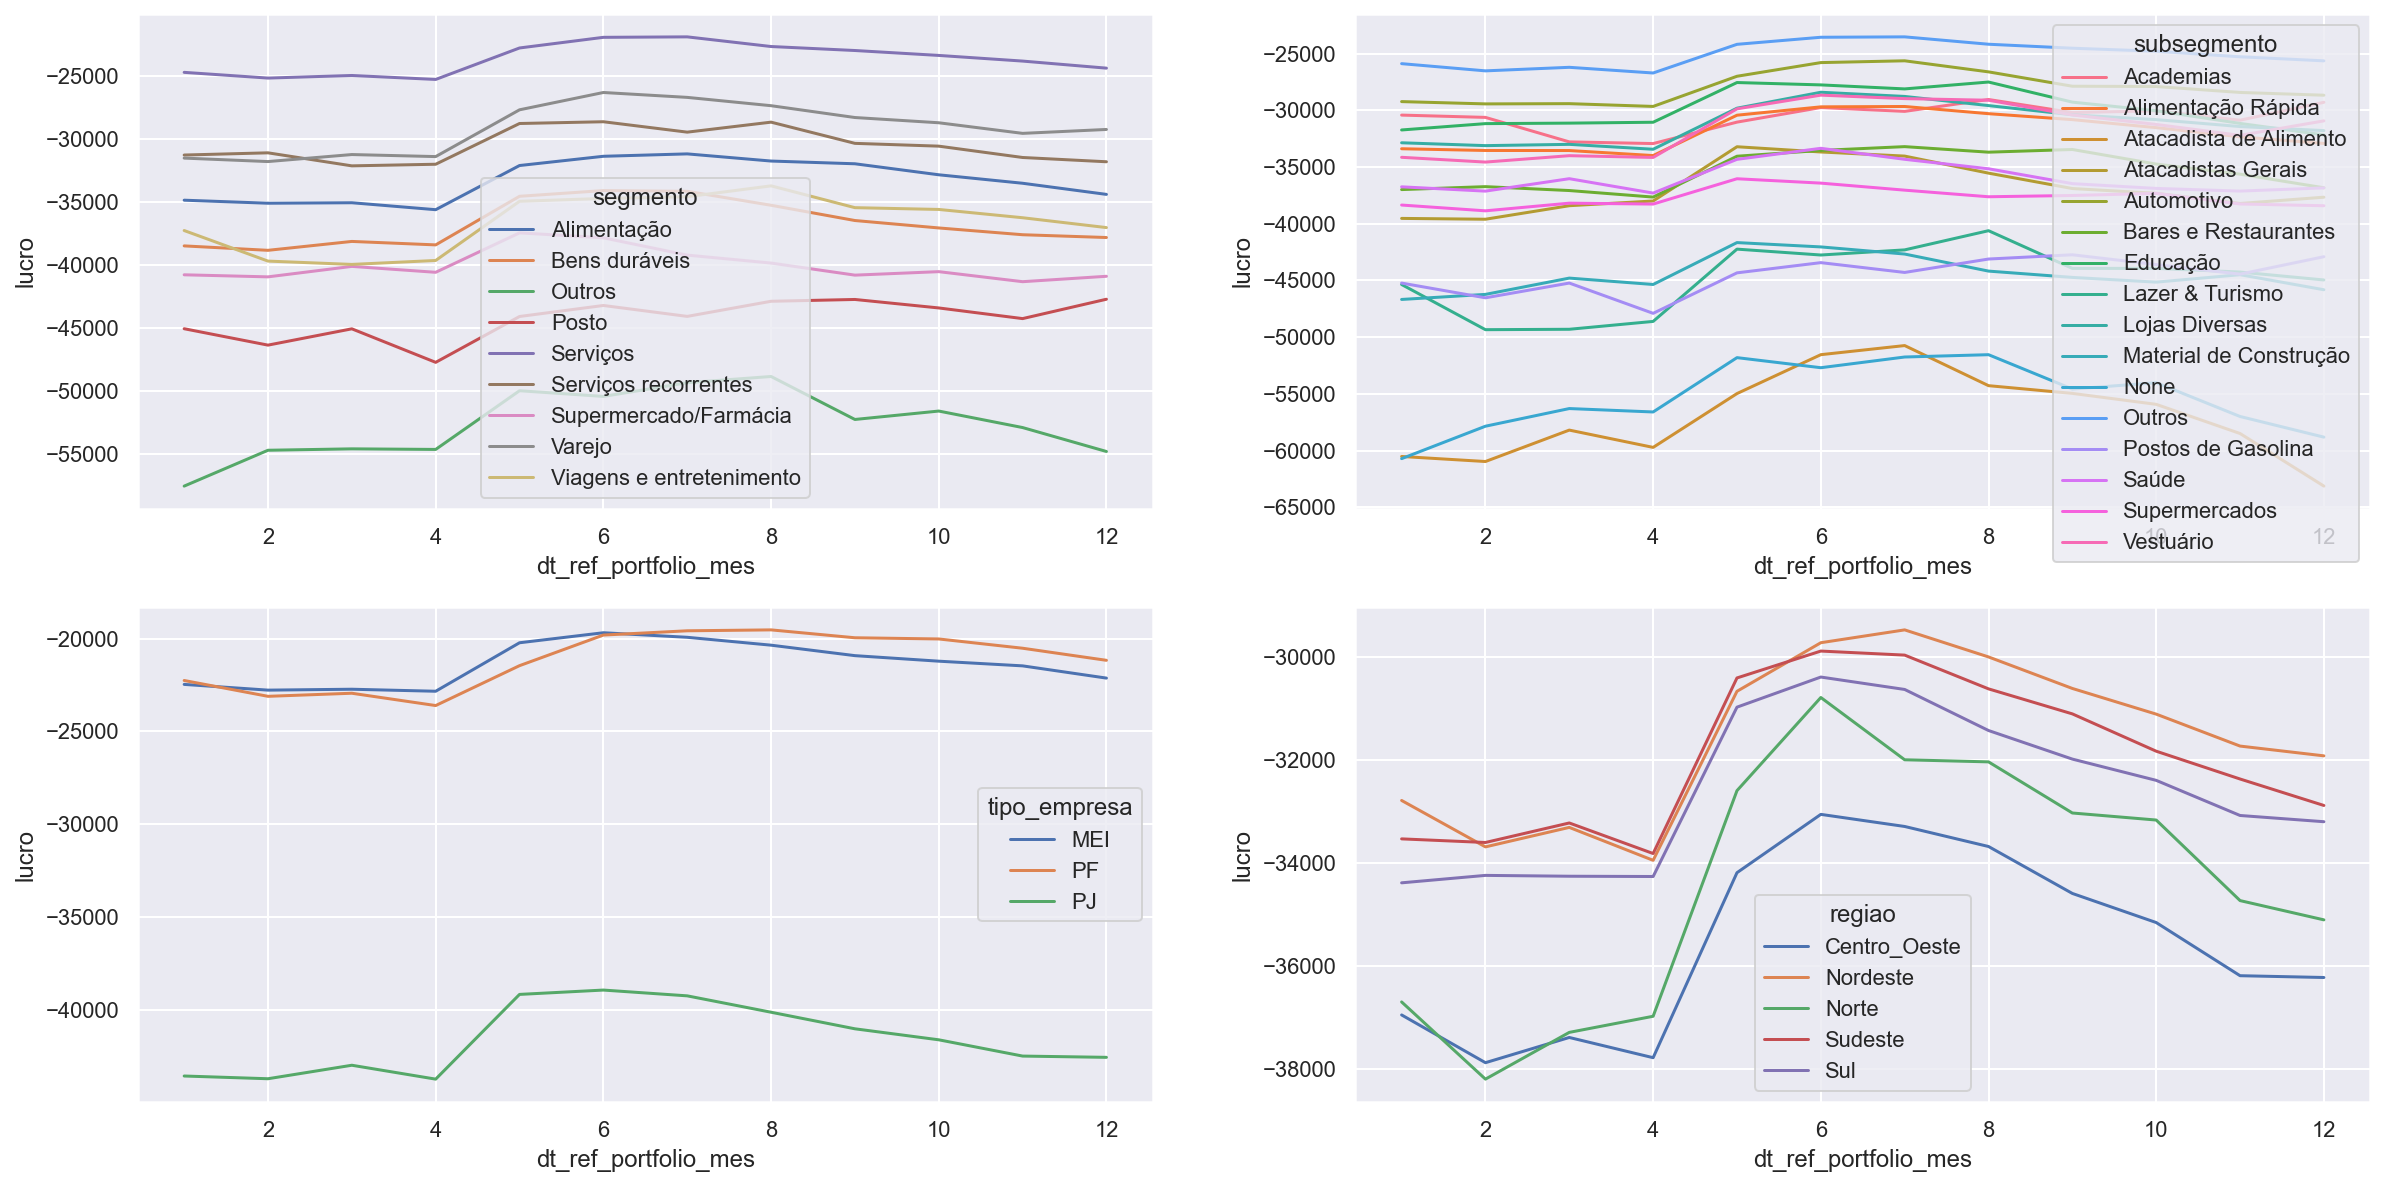

In [26]:
# lucro médio mensal segmento
df_lucro_mensal_segmento = df_geral_tpv_clientes[['segmento','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado','vlr_pgto_realizado']].groupby(['segmento','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado']).sum().reset_index()
df_lucro_mensal_segmento['lucro'] = df_lucro_mensal_segmento['vlr_pgto_realizado'] - df_lucro_mensal_segmento['vlr_desembolsado']
df_lucro_mensal_segmento_medio = df_lucro_mensal_segmento[['segmento','dt_ref_portfolio_mes','lucro']].groupby(['segmento','dt_ref_portfolio_mes']).mean().reset_index()

# lucro médio mensal subsegmento
df_lucro_mensal_subsegmento = df_geral_tpv_clientes[['subsegmento','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado','vlr_pgto_realizado']].groupby(['subsegmento','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado']).sum().reset_index()
df_lucro_mensal_subsegmento['lucro'] = df_lucro_mensal_subsegmento['vlr_pgto_realizado'] - df_lucro_mensal_subsegmento['vlr_desembolsado']
df_lucro_mensal_subsegmento_medio = df_lucro_mensal_subsegmento[['subsegmento','dt_ref_portfolio_mes','lucro']].groupby(['subsegmento','dt_ref_portfolio_mes']).mean().reset_index()

# lucro médio mensal tipo_empresa
df_lucro_mensal_tipo_empresa = df_geral_tpv_clientes[['tipo_empresa','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado','vlr_pgto_realizado']].groupby(['tipo_empresa','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado']).sum().reset_index()
df_lucro_mensal_tipo_empresa['lucro'] = df_lucro_mensal_tipo_empresa['vlr_pgto_realizado'] - df_lucro_mensal_tipo_empresa['vlr_desembolsado']
df_lucro_mensal_tipo_empresa_medio = df_lucro_mensal_tipo_empresa[['tipo_empresa','dt_ref_portfolio_mes','lucro']].groupby(['tipo_empresa','dt_ref_portfolio_mes']).mean().reset_index()

# lucro médio mensal regiao
df_lucro_mensal_regiao = df_geral_tpv_clientes[['regiao','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado','vlr_pgto_realizado']].groupby(['regiao','dt_ref_portfolio_ano','dt_ref_portfolio_mes','vlr_desembolsado']).sum().reset_index()
df_lucro_mensal_regiao['lucro'] = df_lucro_mensal_regiao['vlr_pgto_realizado'] - df_lucro_mensal_regiao['vlr_desembolsado']
df_lucro_mensal_regiao_medio = df_lucro_mensal_regiao[['regiao','dt_ref_portfolio_mes','lucro']].groupby(['regiao','dt_ref_portfolio_mes']).mean().reset_index()

plt.subplot( 2, 2, 1 )
sns.lineplot( x='dt_ref_portfolio_mes', y='lucro',hue='segmento', data=df_lucro_mensal_segmento_medio )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='dt_ref_portfolio_mes', y='lucro',hue='subsegmento', data=df_lucro_mensal_subsegmento_medio )

plt.subplot( 2, 2, 3 )
sns.lineplot( x='dt_ref_portfolio_mes', y='lucro',hue='tipo_empresa', data=df_lucro_mensal_tipo_empresa_medio )

plt.subplot( 2, 2, 4 )
sns.lineplot( x='dt_ref_portfolio_mes', y='lucro',hue='regiao', data=df_lucro_mensal_regiao_medio )

# Número de inadimplentes por segmento

<AxesSubplot:xlabel='regiao', ylabel='contrato_id'>

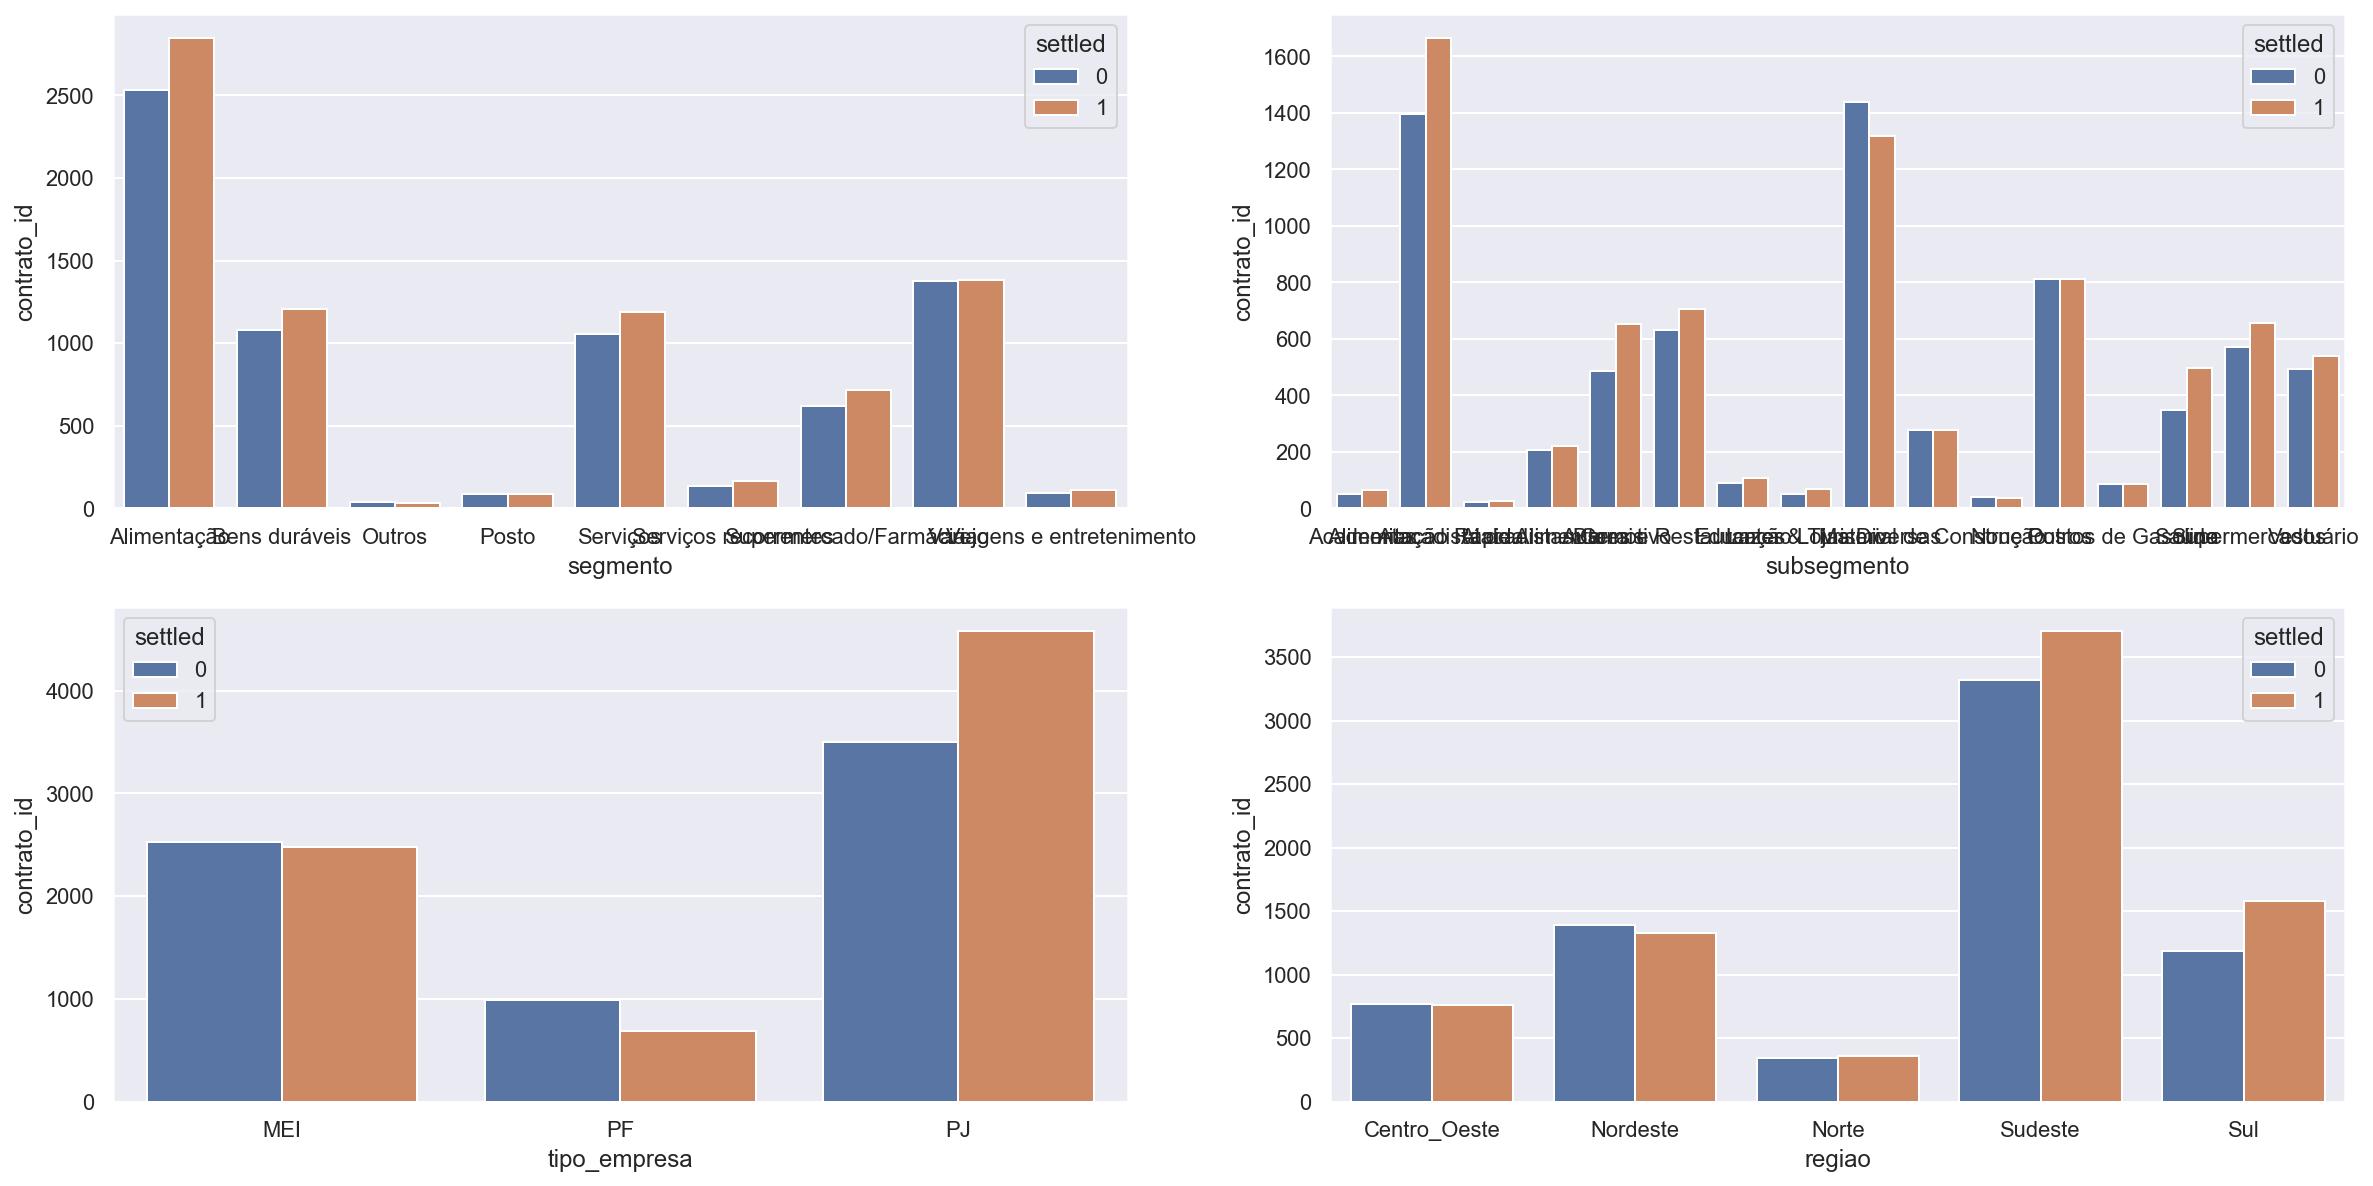

In [27]:
df_contratos_unicos = df_geral_tpv_clientes.drop_duplicates( subset='contrato_id', keep='first' )
df_inadimplentes_por_segmento = df_contratos_unicos[['contrato_id','segmento','settled']].groupby(['segmento','settled']).count().reset_index()

df_contratos_unicos = df_geral_tpv_clientes.drop_duplicates( subset='contrato_id', keep='first' )
df_inadimplentes_por_subsegmento = df_contratos_unicos[['contrato_id','subsegmento','settled']].groupby(['subsegmento','settled']).count().reset_index()

df_contratos_unicos = df_geral_tpv_clientes.drop_duplicates( subset='contrato_id', keep='first' )
df_inadimplentes_por_tipo_empresa = df_contratos_unicos[['contrato_id','tipo_empresa','settled']].groupby(['tipo_empresa','settled']).count().reset_index()

df_contratos_unicos = df_geral_tpv_clientes.drop_duplicates( subset='contrato_id', keep='first' )
df_inadimplentes_por_regiao = df_contratos_unicos[['contrato_id','regiao','settled']].groupby(['regiao','settled']).count().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='segmento', y='contrato_id', hue='settled', data=df_inadimplentes_por_segmento )

plt.subplot( 2, 2, 2 )
sns.barplot( x='subsegmento', y='contrato_id', hue='settled', data=df_inadimplentes_por_subsegmento )

plt.subplot( 2, 2, 3 )
sns.barplot( x='tipo_empresa', y='contrato_id', hue='settled', data=df_inadimplentes_por_tipo_empresa )

plt.subplot( 2, 2 , 4 )
sns.barplot( x='regiao', y='contrato_id', hue='settled', data=df_inadimplentes_por_regiao )

## H3: O valor médio do empréstimo dos clientes que dão prejuízo é 50% mais alto do que os que não dão.
**Verdadeiro**. O valor médio do empréstimo dos clientes que dão prejuízo é aproximadamente 50% maior do que os que não dão.

In [35]:
# lista contratos prejuizo
contratos_prejuizo_lista = contratos_prejuizo['contrato_id'].tolist()

# separando contratos que dão prejuizo dos que nao dao
df_contratos_prejuizo = df_geral_tpv_clientes[df_geral_tpv_clientes['contrato_id'].isin(contratos_prejuizo_lista)]
df_contratos_lucro = df_geral_tpv_clientes[~df_geral_tpv_clientes['contrato_id'].isin(contratos_prejuizo_lista)]

#calculando valores médios de empréstimo
soma_emprestimo_prejuizo = df_contratos_prejuizo[['contrato_id','vlr_desembolsado']].groupby( 'contrato_id' ).sum().reset_index()
soma_emprestimo_lucro = df_contratos_lucro[['contrato_id','vlr_desembolsado']].groupby( 'contrato_id' ).sum().reset_index()

print('O valor médio do empréstimo dos clientes que dão prejuízo é {} vezes maior do que os que não dão'
      .format(soma_emprestimo_prejuizo['vlr_desembolsado'].mean() / soma_emprestimo_lucro['vlr_desembolsado'].mean()))

O valor médio do empréstimo dos clientes que dão prejuízo é 1.4819428585052288 vezes maior do que os que não dão


## H4: Clientes que dão prejuízo tem 20% mais mensagens não entregues do que os que não dão.
**Falso**. Clientes que dão prejuízo tem 39% mais mensagens não entregue do que os que não.

In [36]:
df_all_prejuizo = df_all[df_all['contrato_id'].isin( contratos_prejuizo_lista )]
df_all_prejuizo['status'].value_counts()

NAO ENTREGUE    111174
ENTREGUE         80062
LIDO             41631
RESPONDIDO        1883
Name: status, dtype: int64

In [37]:
df_all_lucro = df_all[~df_all['contrato_id'].isin( contratos_prejuizo_lista )]
df_all_lucro['status'].value_counts()

NAO ENTREGUE    79503
ENTREGUE        57498
LIDO            29534
RESPONDIDO       1309
Name: status, dtype: int64

In [38]:
111174 / 79503

1.3983623259499642

## H5: Clientes que dão prejuízo representam 70% de todos que já foram negativados
**Falso**. Clientes que dão prejuízo representam  apenas 22% dos que já foram negativados.

In [39]:
df_negativados = df_all[df_all['negativado'] == 1 ]
df_negativados_prejuizo = df_negativados[df_negativados['contrato_id'].isin(contratos_prejuizo_lista)]
df_negativados_lucro = df_negativados[~df_negativados['contrato_id'].isin(contratos_prejuizo_lista)]

In [40]:
len(df_negativados_prejuizo['contrato_id'].unique()) / len(df_negativados['contrato_id'].unique())

0.2235813366960908

### Quais são os setores mais negativados?
**1. Alimentação 2. Varejo 3. Serviços**

In [41]:
lista_trinta_e_cinco_por_cento = contratos_prejuizo['contrato_id'].tolist()

df_lista_trinta_e_cinco_por_cento = df_geral_tpv_clientes[df_geral_tpv_clientes['contrato_id'].isin(lista_trinta_e_cinco_por_cento)]
df_lista_trinta_e_cinco_por_cento = df_lista_trinta_e_cinco_por_cento.drop_duplicates( subset=['contrato_id'], keep='first' )
segmentos_lista_trinta_e_cinco_por_cento = df_lista_trinta_e_cinco_por_cento[['contrato_id','segmento']].groupby('segmento').count().reset_index().sort_values('contrato_id', ascending=False)

segmentos_lista_trinta_e_cinco_por_cento

negativados = df_negativados['contrato_id'].to_list()

df_negativacao_setor = df_geral_tpv_clientes[df_geral_tpv_clientes['contrato_id'].isin(negativados)]
df_negativacao_setor = df_negativacao_setor.drop_duplicates( subset=['contrato_id'], keep='first' )
setores_negativacao = df_negativacao_setor[['contrato_id','segmento']].groupby('segmento').count().reset_index().sort_values('contrato_id', ascending=False)

setores_negativacao

segmento  contrato_id
0               Alimentação         2721
7                    Varejo         1539
4                  Serviços         1348
1             Bens duráveis         1297
6     Supermercado/Farmácia          577
5      Serviços recorrentes          212
8  Viagens e entretenimento          112
3                     Posto           85
2                    Outros           39

## H6: 50% dos contratos que dão lucro ainda estão ativos
**Falso**. Dos contratos que dão lucro, apenas 9.96% ainda estão ativos.

In [42]:
# lista de ids dos contratos que dão lucro
contratos_lucro = df_valores_recebidos_por_contrato[df_valores_recebidos_por_contrato['lucro'] > 0]
contratos_lucro_id = contratos_lucro['contrato_id'].tolist()

# filtrando df geral com a lista
df_geral_tpv_clientes_lucro = df_geral_tpv_clientes[df_geral_tpv_clientes['contrato_id'].isin(contratos_lucro_id)]

# verificando quais ainda estão ativos
contratos_lucro_max_datas = df_geral_tpv_clientes_lucro[['contrato_id','status_contrato','dt_ref_portfolio']].groupby( ['contrato_id','status_contrato'] ).max().reset_index()
situacao_atual_contratos = contratos_lucro_max_datas[['contrato_id','status_contrato','dt_ref_portfolio']].groupby('contrato_id').max().reset_index()
contratos_ativos = situacao_atual_contratos[situacao_atual_contratos['status_contrato'] == 'Active' ]

print( 'Dos contratos que dão lucro, {} ainda estão ativos.'.format(len(contratos_ativos)))
print( 'Isso representa {:.2f}% do total de contratos que dão lucro'.format( (len(contratos_ativos)/len(contratos_lucro_id))*100 ))

Dos contratos que dão lucro, 947 ainda estão ativos.
Isso representa 9.96% do total de contratos que dão lucro


### Quais são os setores que mais dão lucro?
**1. Alimentação 2. Varejo 3. Bens Duráveis**

In [43]:
df_setores_lucro = df_geral_tpv_clientes_lucro.drop_duplicates( subset='contrato_id', keep='first')
setores_lucro = df_setores_lucro[['contrato_id','segmento']].groupby('segmento').count().reset_index().sort_values('contrato_id', ascending=False)
setores_lucro

segmento  contrato_id
0               Alimentação         3521
7                    Varejo         1727
1             Bens duráveis         1441
4                  Serviços         1429
6     Supermercado/Farmácia          891
5      Serviços recorrentes          207
8  Viagens e entretenimento          127
3                     Posto          114
2                    Outros           50

## H7: 50% dos contratos que dão prejuízo ainda estão ativos
**Falso**. Dos contratos que dão prejuízo, apenas 31.79% ainda estão ativos.

In [44]:
# lista de ids dos contratos que dão prejuízo
contratos_prejuizo = df_valores_recebidos_por_contrato[df_valores_recebidos_por_contrato['lucro'] < 0]
contratos_prejuizo_id = contratos_prejuizo['contrato_id'].tolist()

# filtrando df geral com a lista
df_geral_tpv_clientes_prejuizo = df_geral_tpv_clientes[df_geral_tpv_clientes['contrato_id'].isin(contratos_prejuizo_id)]

# verificando quais ainda estão ativos
contratos_prejuizo_max_datas = df_geral_tpv_clientes_prejuizo[['contrato_id','status_contrato','dt_ref_portfolio']].groupby( ['contrato_id','status_contrato'] ).max().reset_index()
situacao_atual_contratos_prejuizo = contratos_prejuizo_max_datas[['contrato_id','status_contrato','dt_ref_portfolio']].groupby('contrato_id').max().reset_index()
contratos_ativos_prejuizo = situacao_atual_contratos_prejuizo[situacao_atual_contratos_prejuizo['status_contrato'] == 'Active' ]

print( 'Dos contratos que dão prejuízo, {} ainda estão ativos.'.format(len(contratos_ativos_prejuizo)))
print( 'Isso representa {:.2f}% do total de contratos que dão prejuízo'.format( (len(contratos_ativos_prejuizo)/len(contratos_prejuizo_id))*100 ))

Dos contratos que dão prejuízo, 1668 ainda estão ativos.
Isso representa 31.79% do total de contratos que dão prejuízo


## H8: 70% dos contratos já foram quitados.
**Falso**. Apenas 52.49% dos contratos já foram quitados.

In [45]:
contratos_unicos = df_geral_tpv_clientes[['contrato_id','settled']].groupby( 'contrato_id' ).max().reset_index()
contratos_quitados = contratos_unicos[contratos_unicos['settled'] == 1]

print('{:.2f}% dos contratos já foram quitados'.format((len(contratos_quitados)/len(contratos_unicos))*100))

52.49% dos contratos já foram quitados


### Quais setores mais quitaram contratos?
**1. Alimentação 2. Bens Duráveis 3. Varejo**

In [46]:
setores_quitados = contratos_quitados['contrato_id'].tolist()
df_setores_quitados = df_geral_tpv_clientes_lucro[df_geral_tpv_clientes['contrato_id'].isin(setores_quitados)]
df_setores_quitados = df_setores_quitados.drop_duplicates( subset='contrato_id', keep='first')
segmentos_quitados = df_setores_quitados[['contrato_id','segmento']].groupby('segmento').count().reset_index().sort_values('contrato_id', ascending=False)
segmentos_quitados

C:\Users\mathe\AppData\Local\Temp\ipykernel_20792\3773022128.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_setores_quitados = df_geral_tpv_clientes_lucro[df_geral_tpv_clientes['contrato_id'].isin(setores_quitados)]


segmento  contrato_id
0               Alimentação         2656
7                    Varejo         1252
1             Bens duráveis         1076
4                  Serviços         1056
6     Supermercado/Farmácia          672
5      Serviços recorrentes          151
8  Viagens e entretenimento          101
3                     Posto           83
2                    Outros           33

## H9: 30% dos clientes são bons pagadores ( nunca foram comunicados ).
**Falso** Apenas 16.95% dos clientes são bons pagadores.

In [47]:
bons_pagadores = (len(df_geral_tpv_clientes['nr_documento'].unique()) - len( df_all['nr_documento'].unique() )) / len(df_geral_tpv_clientes['nr_documento'].unique() )
print( '{:.2f}% dos clientes são bons pagadores. Nunca receberam um comunicado de cobrança.'.format( bons_pagadores * 100 ) )

16.95% dos clientes são bons pagadores. Nunca receberam um comunicado de cobrança.


### Quais setores tem mais clientes bom pagadores?
**1. Alimentação 2. Supermercado/Farmácia 3. Varejo**

In [48]:
mau_pagadores = df_all['contrato_id'].tolist()

df_bons_pagadores = df_geral_tpv_clientes[~df_geral_tpv_clientes['contrato_id'].isin(mau_pagadores)]
df_bons_pagadores = df_bons_pagadores.drop_duplicates( subset='contrato_id', keep='first' )

setores_bons_pagadores = df_bons_pagadores[['contrato_id','segmento']].groupby('segmento').count().reset_index().sort_values('contrato_id', ascending=False)
setores_bons_pagadores

segmento  contrato_id
0               Alimentação         1151
6     Supermercado/Farmácia          447
7                    Varejo          357
1             Bens duráveis          337
4                  Serviços          190
3                     Posto           47
8  Viagens e entretenimento           24
2                    Outros           13
5      Serviços recorrentes           13

# 3.0. Análise Multivariada

## 3.1. Variáveis Numéricas

### 3.1.1. Portfolio Geral TPV Clientes

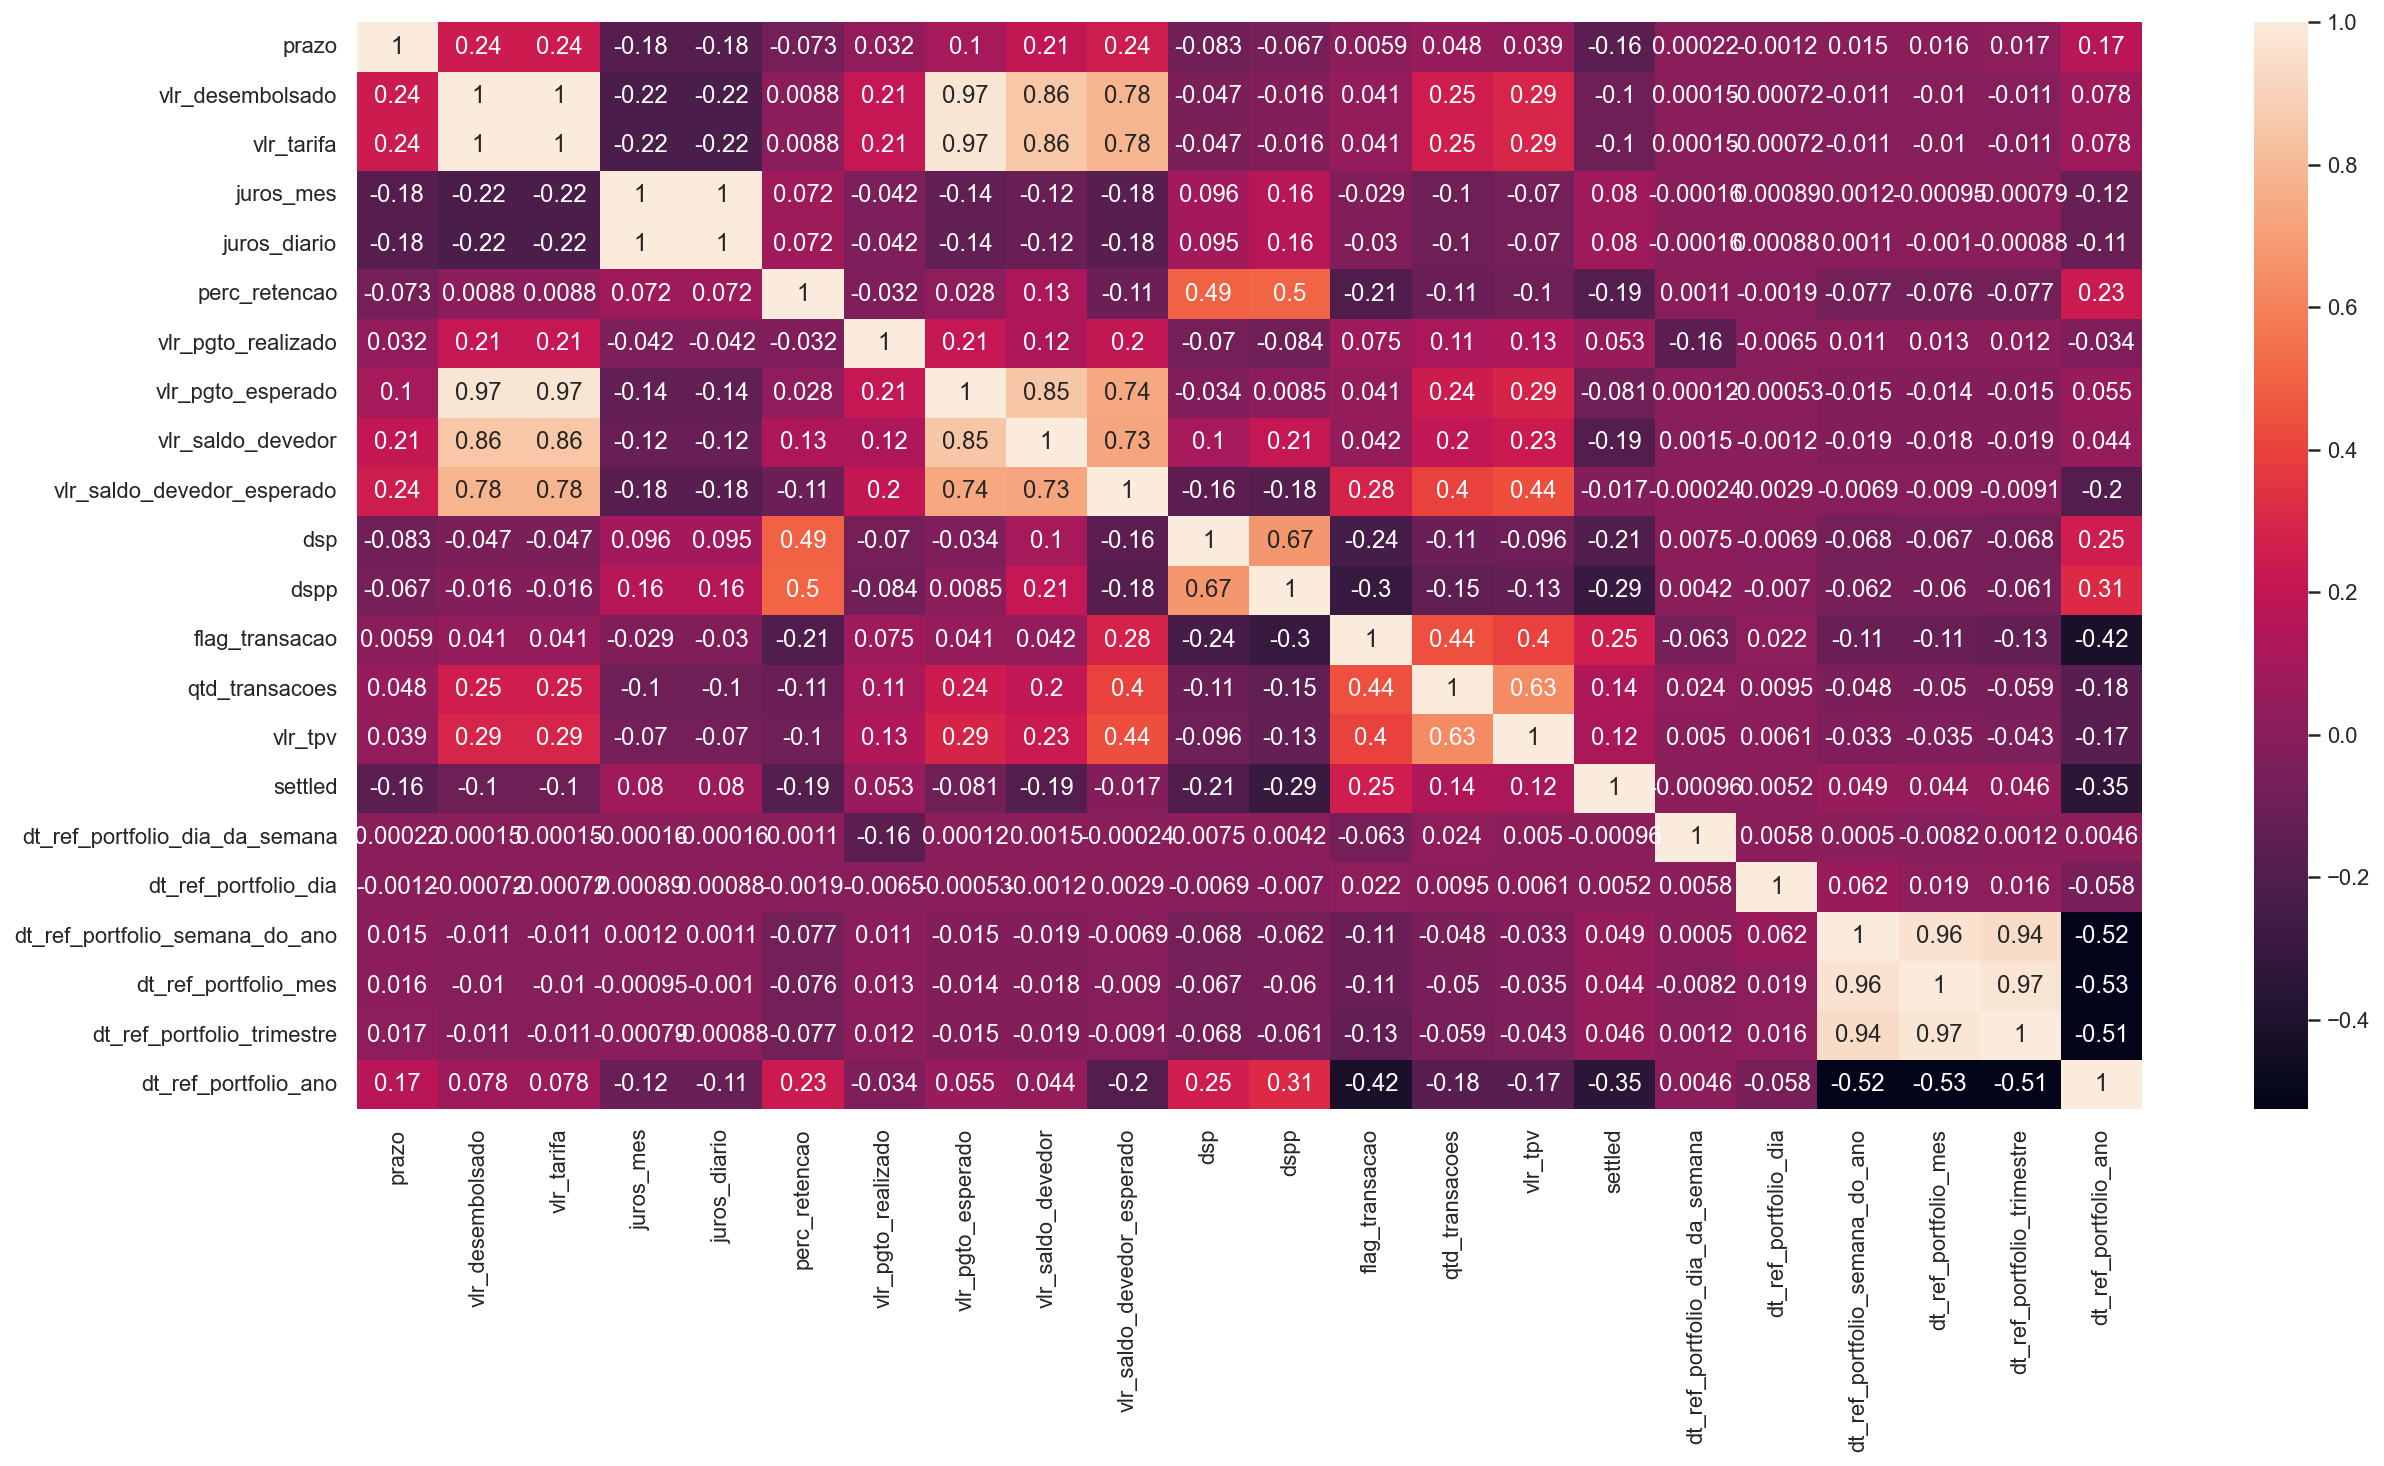

In [49]:
num_features_geral = df_geral_tpv_clientes.select_dtypes( include=['int64','float64'])
correlation_geral = num_features_geral.corr( method = 'pearson' )
sns.heatmap( correlation_geral, annot=True );

## 3.2. Variáveis Categóricas

### 3.2.1. Portfolio Geral TPV Clientes

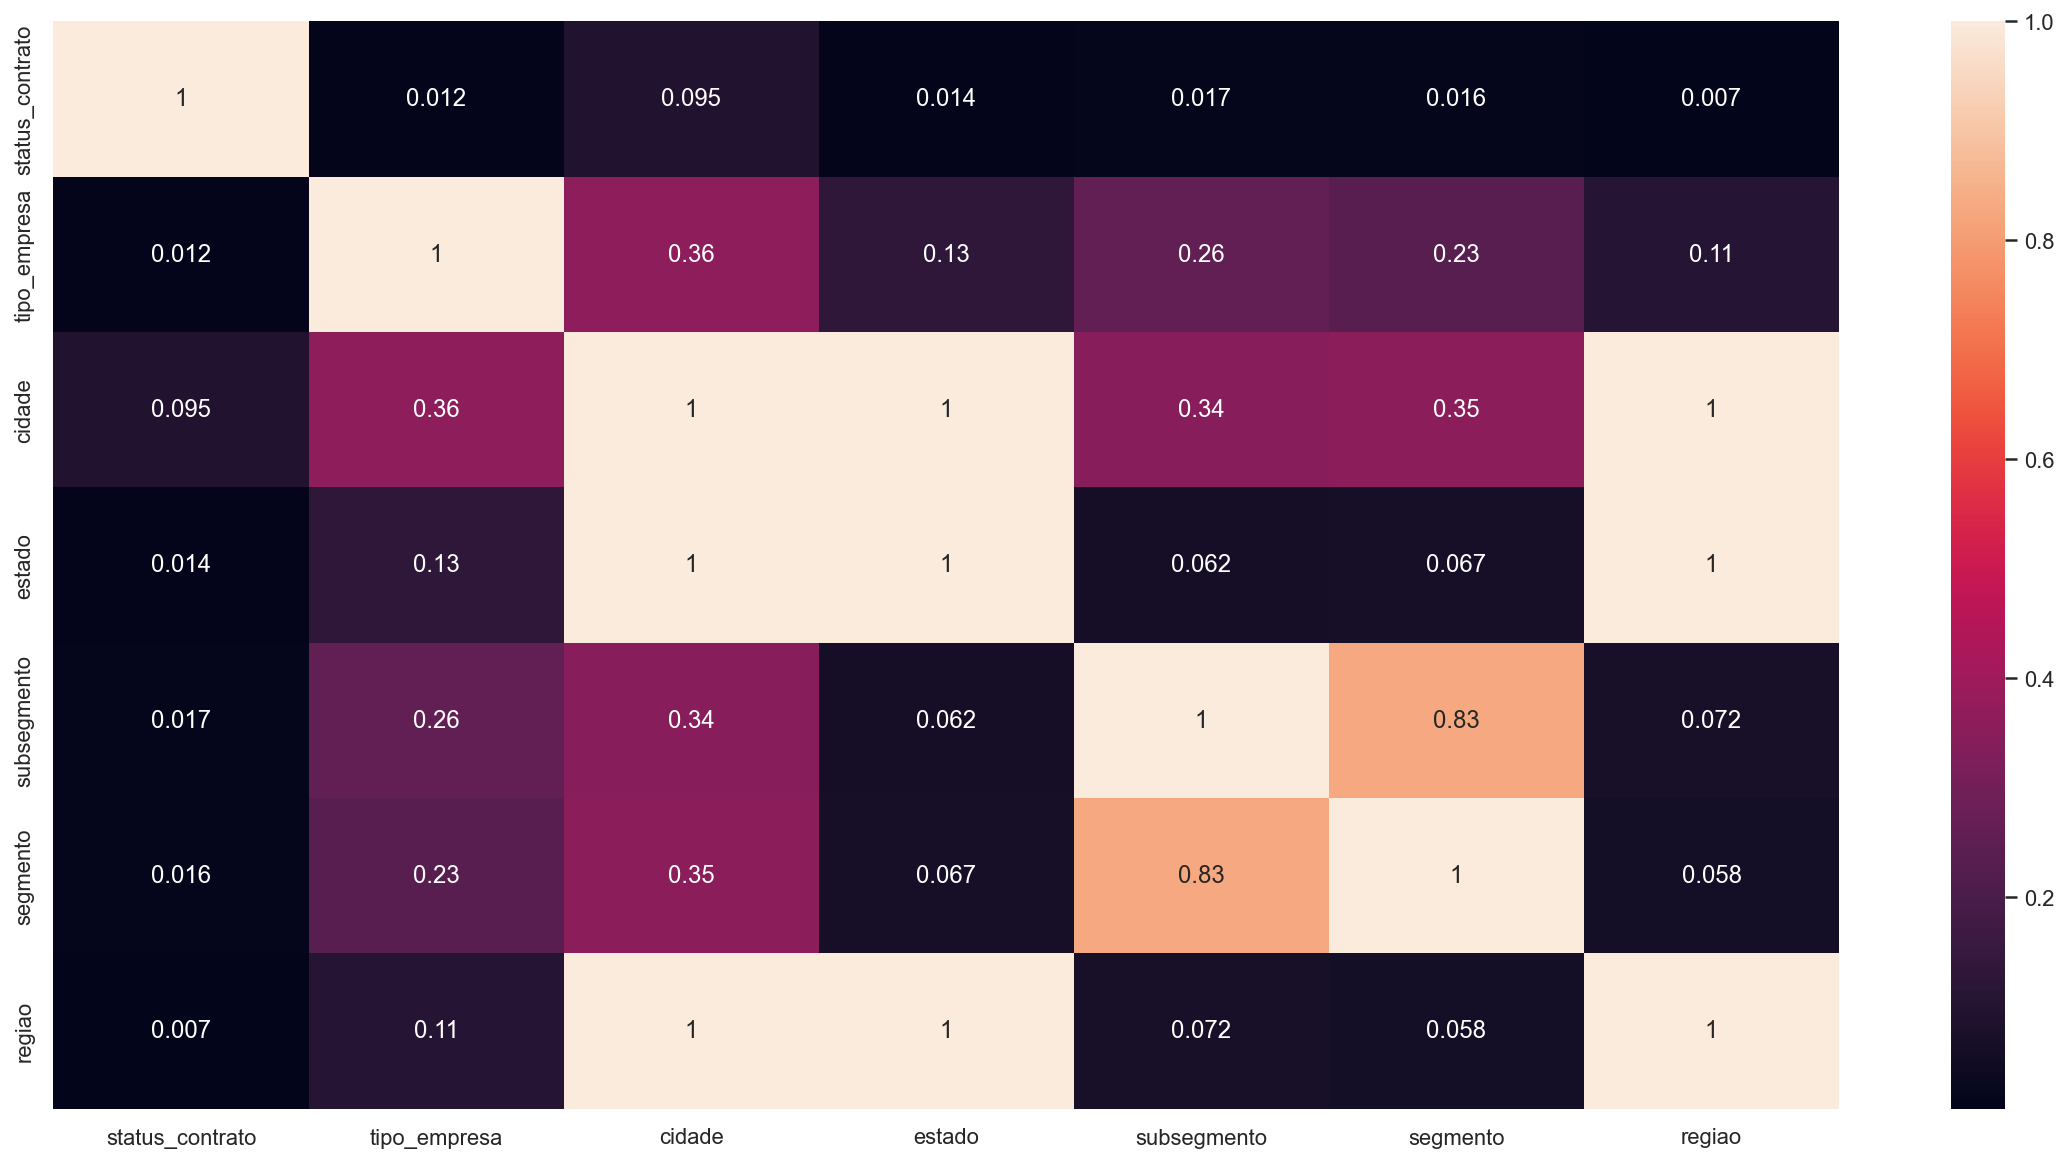

In [50]:
cat_attributes_geral = df_geral_tpv_clientes.select_dtypes( include='object' )
cat_attributes_lista = cat_attributes_geral.drop( columns=['contrato_id','nr_documento'] ).columns.tolist()
plot_cramer_v( cat_attributes_lista, cat_attributes_geral );

### 3.2.2. Portfolio Comunicados

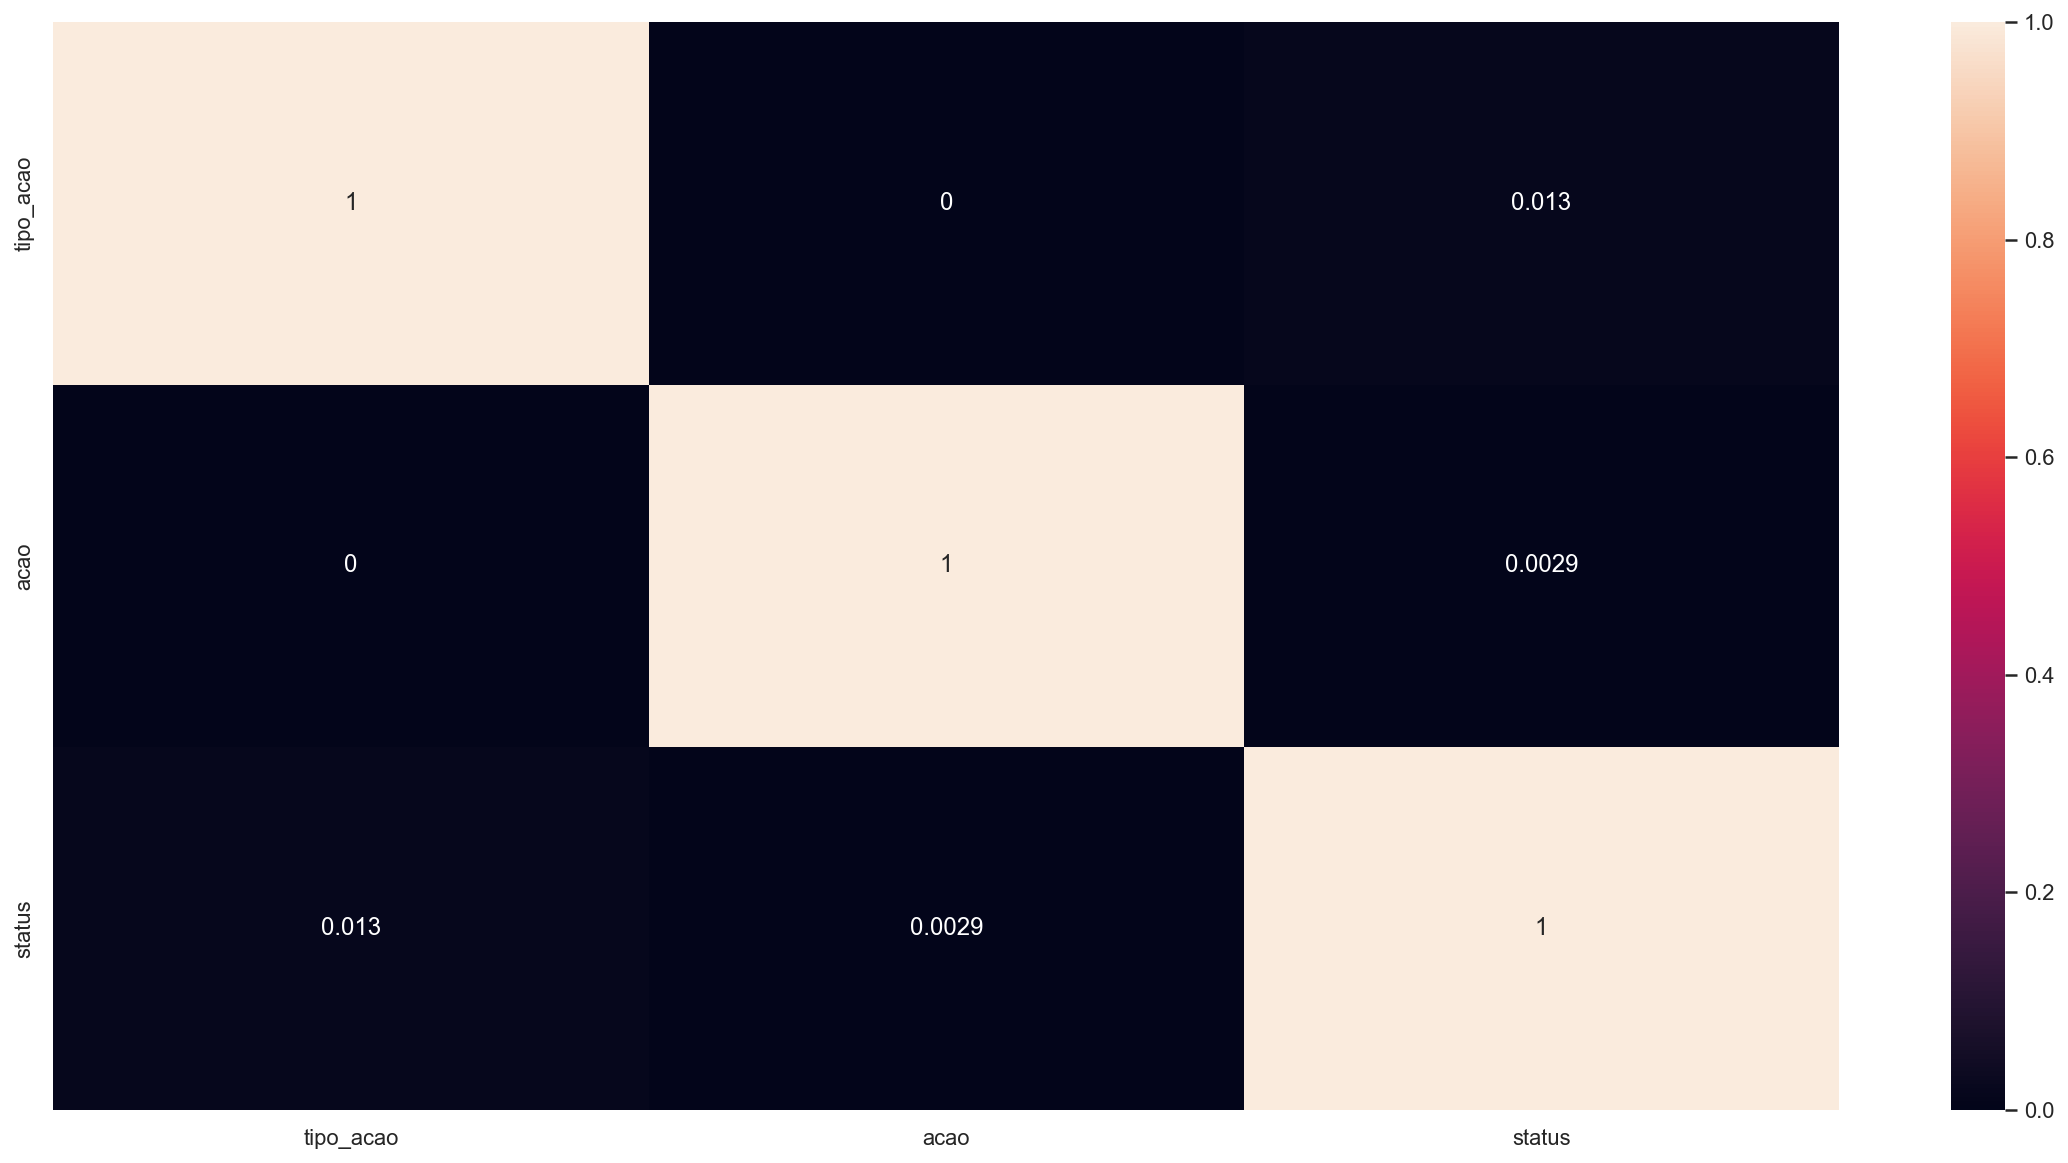

In [51]:
cat_attributes_comunicados = df_portfolio_comunicados.select_dtypes( include='object' )
cat_attributes_lista_comunicados = cat_attributes_comunicados.drop( columns=['contrato_id'] ).columns.tolist()
plot_cramer_v( cat_attributes_lista_comunicados, cat_attributes_comunicados );